# Zrozumienie biznesu

Celem niniejszego projektu jest poprawa jakości prognoz ilości sprzedaży artykułów spożywczych objętych promocjami w przedsiębiorstwie działającym na rynku FMCG. Projekt skupia się na zbadaniu możliwości wykorzystania zaawansowanych metod data science, takich jak metody bayesian, lasy losowe, regresja oraz sieci neuronowe, w celu uwzględnienia aktualnych trendów sprzedaży oraz prognozowania dla produktów bez historii sprzedaży.

Praca badawcza koncentruje się na jednym z asortymentów sieci sprzedaży i będzie wykorzystywać dane z własnego data warehouse firmy, obejmujące takie informacje jak cena produktu, dzienna sprzedaż i obrót na sklep, rodzaj promocji oraz cenę przed promocją. Istotne jest zrozumienie specyfiki rynku FMCG, konkurencji oraz preferencji i potrzeb klientów, co pozwoli na lepsze dostosowanie oferty promocyjnej do ich oczekiwań.

Eksperymenty na danych sprzedażowych z ostatnich 3 lat zostaną przeprowadzone w celu porównania skuteczności różnych metod w przewidywaniu sprzedaży artykułów promocyjnych. Wyniki tych badań mogą mieć istotne znaczenie dla firm, które chcą zoptymalizować swoje kampanie promocyjne i zwiększyć swoje zyski.


Plan wdrożenia obejmuje analizę danych, opracowanie i testowanie różnych modeli predykcyjnyh oraz wdrożenie modelu o najlepszych parametrach w praktyce. Realizacja projektu będzie przebiegać zgodnie z metodologią CRISP-DM.
<br>
https://www.ibm.com/docs/pl/spss-modeler/saas?topic=guide-introduction-crisp-dm
<br>
<img src="img/crisp_process.jpg" alt = "CRISP-DM" width = "300" height = "300" align="left">


## Import

### Import bibliotek

In [ ]:
%%capture
pip install pmdarima

In [ ]:
# Podstawowe biblioteki
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
import warnings
from tqdm import tqdm
import gc

# Opcje
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
sns.color_palette("magma", as_cmap=True)
warnings.filterwarnings('ignore', category=FutureWarning)
%matplotlib inline

import functions as ff

# Klasteryzacja
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.vq import whiten, kmeans, vq
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# Random
import random
random.seed(42)

#EDA
from statsmodels.tsa.seasonal import seasonal_decompose

# Metryki
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Strojenie parametrów modelów
from itertools import product
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
import random
from random import randint

# Cross walidacja danych typu time series
from sklearn.model_selection import TimeSeriesSplit

# Model podstawowy
from sklearn.neighbors import KNeighborsRegressor

# SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prophet
from prophet import Prophet


# Lasy losowe
import xgboost as xgb
from xgboost import XGBRFRegressor

# Transformacje danych
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler


# Sieci neuronowe
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

### Import danych

In [ ]:
df = pd.read_csv('CSV/dane.csv', sep=',', parse_dates=['DATA'])
random_values = [random.randint(1, 238) for _ in range(150)]
df = df[df['MARKET_ID'].isin(random_values)]

In [ ]:
kalendarz = pd.read_csv('CSV/kalendarz.csv',sep=';', parse_dates=['DATA'], date_parser=ff.dateparser)
del kalendarz[kalendarz.columns[10]]
HICP = pd.read_csv('CSV/HICP.csv', sep=';',parse_dates=['DATA'], date_parser=ff.dateparser)
promo_ceny = pd.read_csv('CSV/PROMO_CENY.csv', sep=';',parse_dates=['DATA'])

## Wstępne opisanie danych

In [ ]:
df.head()

DATA  MARKET_ID  GRUPA_ID  ART_ID  OBROT  ILOSC  \
696 2019-09-02          2        19       1    0.0    0.0   
697 2019-09-02          2         8       2    0.0    0.0   
698 2019-09-02          2         8       3    0.0    0.0   
699 2019-09-02          2         8       4    0.0    0.0   
700 2019-09-02          2         8       5    0.0    0.0   

                            NAZWA  
696  FCHKWROVC QD JROULRGU FDSYVR  
697                   JHSDL ERSCR  
698            JHSDL FCHS QH YRFD  
699                   JHSDL WDSGU  
700              JHSDL KRLGRSDZFH

DataFrame **df** tworzy główną oś i prezentuje dane dotyczące sprzedaży różnych artykułów spożywczych w różnych marketach w określonym dniu.  
Kolumny zawierają następujące informacje:

*DATA*: data sprzedaży (np. 2020-02-13),  
*MARKET_ID*: unikalne ID marketu, w którym doszło do sprzedaży (np. 1, 4, 6),  
*GRUPA_ID*: identyfikator grupy produktowej, do której należy dany artykuł (np. 19, 8),  
*ART_ID*: unikalne ID artykułu (np. 1, 2),  
*OBROT*: całkowita wartość sprzedaży danego artykułu w PLN (np. 3.31, 22.21),  
*ILOSC*: ilość sprzedanych sztuk danego artykułu (np. 1.00, 2.92),  
*NAZWA*: zakodowana nazwa artykułu (np. "FCHKWROVC QD JROULRGU FDSYVR").

In [ ]:
df.describe().T

count        mean         std      min    25%    50%    75%  \
MARKET_ID  89277712.0  119.642269   69.127846     2.00   58.0  118.0  177.0   
GRUPA_ID   89277712.0   13.910693    8.134427     1.00    5.0   14.0   22.0   
ART_ID     89277712.0  348.548119  200.995705     1.00  175.0  349.0  522.0   
OBROT      89277712.0   17.559285   89.004770  -699.20    0.0    0.0    0.0   
ILOSC      89277712.0    4.080592   26.660253 -1024.34    0.0    0.0    0.0   

                max  
MARKET_ID    237.00  
GRUPA_ID      26.00  
ART_ID       697.00  
OBROT      10973.85  
ILOSC       6003.23

In [ ]:
df.shape

(89277712, 7)

**Obserwacja:** Kolumny 'OBROT' i 'ILOSC' przyjmują wartości ujemne - wymagane jest oczyszczenie danych.
<br>
<br>

In [ ]:
kalendarz.head()

DATA  Nr_dn_tyg  Nr_dn_mies  Nr_mies  Nr_tyg  Nr_rok  Dn_handlowy  \
0 2019-01-01          2           1        1       1    2019            0   
1 2019-01-02          3           2        1       1    2019            1   
2 2019-01-03          4           3        1       1    2019            1   
3 2019-01-04          5           4        1       1    2019            1   
4 2019-01-05          6           5        1       1    2019            1   

   Hot_day  Hot_day_Xmass  Hot_day_Wlkn  
0        1              0             0  
1        0              0             0  
2        0              0             0  
3        0              0             0  
4        0              0             0

In [ ]:
kalendarz.describe().T

count         mean        std     min     25%     50%     75%  \
Nr_dn_tyg      1826.0     4.001643   1.999862     1.0     2.0     4.0     6.0   
Nr_dn_mies     1826.0    15.727820   8.801735     1.0     8.0    16.0    23.0   
Nr_mies        1826.0     6.523549   3.449478     1.0     4.0     7.0    10.0   
Nr_tyg         1826.0    26.615553  15.065085     1.0    14.0    27.0    40.0   
Nr_rok         1826.0  2020.999452   1.414407  2019.0  2020.0  2021.0  2022.0   
Dn_handlowy    1826.0     0.855422   0.351772     0.0     1.0     1.0     1.0   
Hot_day        1826.0     0.035597   0.185334     0.0     0.0     0.0     0.0   
Hot_day_Xmass  1826.0    -0.217963   1.752220   -14.0     0.0     0.0     0.0   
Hot_day_Wlkn   1826.0    -0.210843   1.766325   -14.0     0.0     0.0     0.0   

                  max  
Nr_dn_tyg         7.0  
Nr_dn_mies       31.0  
Nr_mies          12.0  
Nr_tyg           53.0  
Nr_rok         2023.0  
Dn_handlowy       1.0  
Hot_day           1.0  
Hot_day_Xmass     7.0  
Hot_day_Wlkn      7.0

Do projektu zostanie użyty zewnętrzny dataframe **kalendarz** zawierający informacje takie jak numery dni tygodnia, miesiąca i roku, czy dany dzień był dniem handlowym oraz inne specjalne oznaczenia dni.  
Kolumny zawierają następujące informacje:

*DATA*: data (np. 2019-01-01, 2019-01-02),
*Nr_dn_tyg*: numer dnia tygodnia (np. 2 - wtorek, 3 - środa),  
*Nr_dn_mies*: numer dnia miesiąca (np. 1, 2),  
*Nr_mies*: numer miesiąca (np. 1 - styczeń),  
*Nr_tyg*: numer tygodnia w roku (np. 1),  
*Nr_rok*: rok (np. 2019),  
*Dn_handlowy*: oznaczenie, czy dany dzień był dniem handlowym (1 - tak, 0 - nie),  
*Hot_day*: oznaczenie, czy dany dzień był dniem specjalnym (1 - tak, 0 - nie),  
*Hot_day_Xmass*: oznaczenie, czy dany dzień był dniem świątecznym (skala od -14 do 7, gdzie -14 oznacza 14 dni przed świętem),    
*Hot_day_Wlkn*: oznaczenie, czy dany dzień był dniem wolnym od pracy ((skala od -14 do 7, gdzie -14 oznacza 14 dni przed świętem).
<br>
<br>

In [ ]:
promo_ceny.head()

DATA  ART_ID  CENA_NP  CENA_AP  PRZECENA  PROMO_KOD
0 2019-09-02       1     3.49     3.49       0.0          0
1 2019-09-03       1     3.49     3.49       0.0          0
2 2019-09-04       1     3.49     3.49       0.0          0
3 2019-09-05       1     3.49     3.49       0.0          0
4 2019-09-06       1     3.49     3.49       0.0          0

DataFrame **promo_ceny** prezentuje dane dotyczące cen oraz promocji produktów w określonym czasie.  
Kolumny zawierają następujące informacje:

*DATA*: data, na którą dotyczy dany wiersz (np. 2019-06-06, 2019-06-07),  
*ART_ID*: unikalny identyfikator produktu (np. 362),  
*CENA_NP*: cena normalna, w przypadku promocji przyjmuje ostatnią cenę przed promocją (np. 1.99),  
*CENA_AP*: cena promocyjna w przypadku występowaniu promocji, w przypadku braku promocji przyjmuje wartośc w kolumny CENA_NP (np. 2.99),  
*PRZECENA*: procent obniżki w przypadku obniżenia ceny w trakcie promocji (np. 0.333) ,  
*PROMO_KOD*: kod promocji związanej z danym produktem (np. 13).

In [ ]:
promo_ceny.describe().T

count        mean         std  min     25%     50%     75%  \
ART_ID     681470.0  320.239845  187.725068  1.0  156.00  318.00  483.00   
CENA_NP    681470.0    7.269196    5.321974  0.1    4.49    5.99    8.99   
CENA_AP    681470.0    7.211979    5.315129  0.1    4.49    5.99    8.56   
PRZECENA   681470.0    0.007850    0.053133  0.0    0.00    0.00    0.00   
PROMO_KOD  681470.0    0.621079    7.751325  0.0    0.00    0.00    0.00   

               max  
ART_ID     697.000  
CENA_NP     55.920  
CENA_AP     55.920  
PRZECENA     0.841  
PROMO_KOD  154.000

**Obserwacja:** W tabelach *kalendarz* oraz *promo_ceny* istnieją kolumny, które reprezentują dane zmienne kategoryczne - wymagane jest dostosowanie typu danych.
<br>
<br>

In [ ]:
HICP.head(2)

DATA   HICP
0 2019-01-01  103.0
1 2019-01-02  103.0

DataFrame **HICP** prezentuje dane dotyczące wskaźnika harmonizowanego indeksu cen konsumpcyjnych (HICP) w określonym czasie. Kolumny zawierają następujące informacje:

*DATA*: data, na którą dotyczy dany wiersz (np. 2019-01-01, 2019-01-02),  
*HICP*: wartość wskaźnika harmonizowanego indeksu cen konsumpcyjnych (np. 103.0).

HICP jest miarą inflacji, która jest używana przez Unię Europejską i inne międzynarodowe organizacje do monitorowania i porównywania cen towarów i usług konsumpcyjnych między krajami. Ten DataFrame może być wykorzystany do analizy zmian inflacji w czasie lub do porównania poziomów inflacji między różnymi okresami.
<br>

## Preprocessing danych oraz feature engineering

### Preprocessing

In [ ]:
df.loc[df['ILOSC'] <= 0, 'ILOSC'] = 0 #wyzerowanie wierszy dla których sprzedaż wynosi zero lub jest ujemna (błąd)
df.loc[df['ILOSC'] <= 0, 'OBROT'] = 0 
df.loc[df['OBROT'] <= 0, 'OBROT'] = 0 #wyzerowanie wierszy dla których obrot wynosi zero lub jest ujemny (błąd)
df.loc[df['OBROT'] <= 0, 'ILOSC'] = 0

In [ ]:
df.head()

DATA  MARKET_ID  GRUPA_ID  ART_ID  OBROT  ILOSC  \
696 2019-09-02          2        19       1    0.0    0.0   
697 2019-09-02          2         8       2    0.0    0.0   
698 2019-09-02          2         8       3    0.0    0.0   
699 2019-09-02          2         8       4    0.0    0.0   
700 2019-09-02          2         8       5    0.0    0.0   

                            NAZWA  
696  FCHKWROVC QD JROULRGU FDSYVR  
697                   JHSDL ERSCR  
698            JHSDL FCHS QH YRFD  
699                   JHSDL WDSGU  
700              JHSDL KRLGRSDZFH

In [ ]:
df.sort_values(['ART_ID', 'MARKET_ID', 'DATA'], inplace=True)

In [ ]:
mask = df['ILOSC'] != 0
df['CENA_MARKET'] = np.round(np.divide(df['OBROT'][mask], df['ILOSC'][mask]),4) #obliczenie średniej ceny sprzedaży per market 
                                                                    #cena uwzględnia ewentualne przeceny produktów
#df['CENA_MARKET'] = df.groupby(['MARKET_ID', 'ART_ID'])['CENA_MARKET'].transform(lambda x: x.fillna(method='ffill')).fillna(method='bfill')
#df['CENA_MARKET'] = df.groupby('ART_ID')['CENA_MARKET'].transform(lambda x: x.fillna(method='ffill')).fillna(method='bfill')

In [ ]:
df.isnull().sum()

DATA                  0
MARKET_ID             0
GRUPA_ID              0
ART_ID                0
OBROT                 0
ILOSC                 0
NAZWA                 0
CENA_MARKET    68247708
dtype: int64

In [ ]:
df.describe().T

count        mean         std   min      25%       50%  \
MARKET_ID    89277712.0  119.642269   69.127846  2.00   58.000  118.0000   
GRUPA_ID     89277712.0   13.910693    8.134427  1.00    5.000   14.0000   
ART_ID       89277712.0  348.548119  200.995705  1.00  175.000  349.0000   
OBROT        89277712.0   17.559483   89.004489  0.00    0.000    0.0000   
ILOSC        89277712.0    4.080637   26.659994  0.00    0.000    0.0000   
CENA_MARKET  21030004.0    5.932942    3.799394  0.01    3.515    4.7546   

               75%       max  
MARKET_ID    177.0    237.00  
GRUPA_ID      22.0     26.00  
ART_ID       522.0    697.00  
OBROT          0.0  10973.85  
ILOSC          0.0   6003.23  
CENA_MARKET    7.6   1184.50

**Obserwacja:** Kolumna 'CENA_MARKET' zawiera wartości odstające (błędne) - konieczne jest oczyszczenie danych.

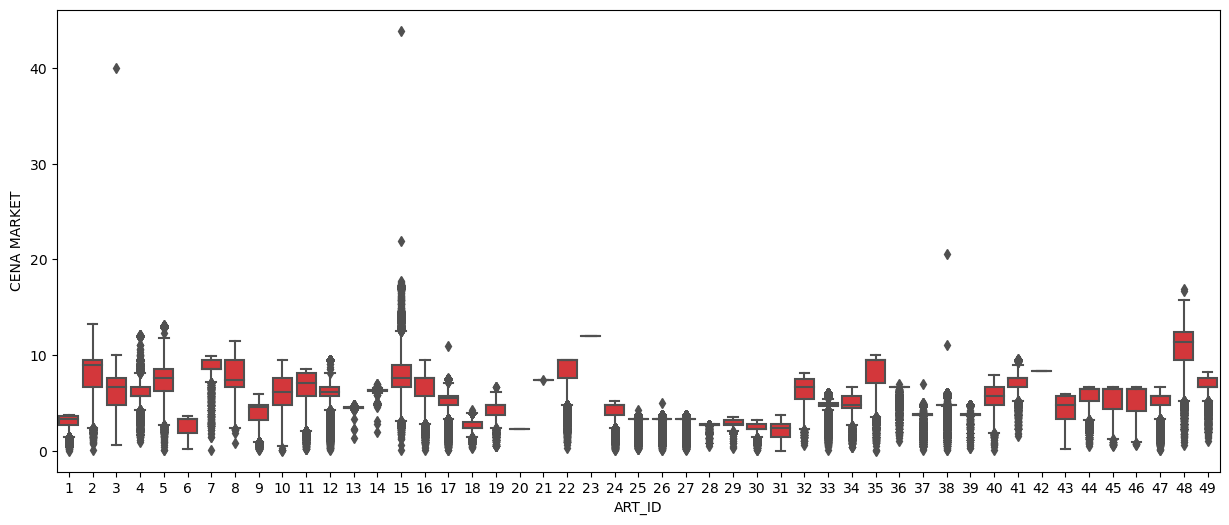

In [ ]:
filtered_df = df[df['ART_ID'] < 50]
colors = ["#ED1D23"]
plt.figure(figsize=(15, 6))
sns.boxplot(data=filtered_df, x="ART_ID", y="CENA_MARKET", palette=sns.color_palette(colors * len(filtered_df["ART_ID"].unique())))
plt.xlabel("ART_ID")
plt.ylabel("CENA MARKET")
plt.show()

**Obserwacja:** Istnieją artykuły posiadające skrajnie wysokie ceny - jest to błąd danych i obserwacje zostaną usunięte.

Zamiana wartości odstających na średnią za pomocą metody IQR:

In [ ]:
mask = df['CENA_MARKET'] != 0
q1 = df[mask].groupby("ART_ID")["CENA_MARKET"].quantile(0.25)
q3 = df[mask].groupby("ART_ID")["CENA_MARKET"].quantile(0.75)
iqr = q3 - q1

upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

mean_values = df[mask].groupby("ART_ID")["CENA_MARKET"].mean()
df["CENA_MARKET"] = df.groupby("ART_ID")["CENA_MARKET"].transform(lambda x: x.mask(x > upper_bound.loc[x.name], mean_values[x.name]).mask(x < lower_bound.loc[x.name], mean_values[x.name]))

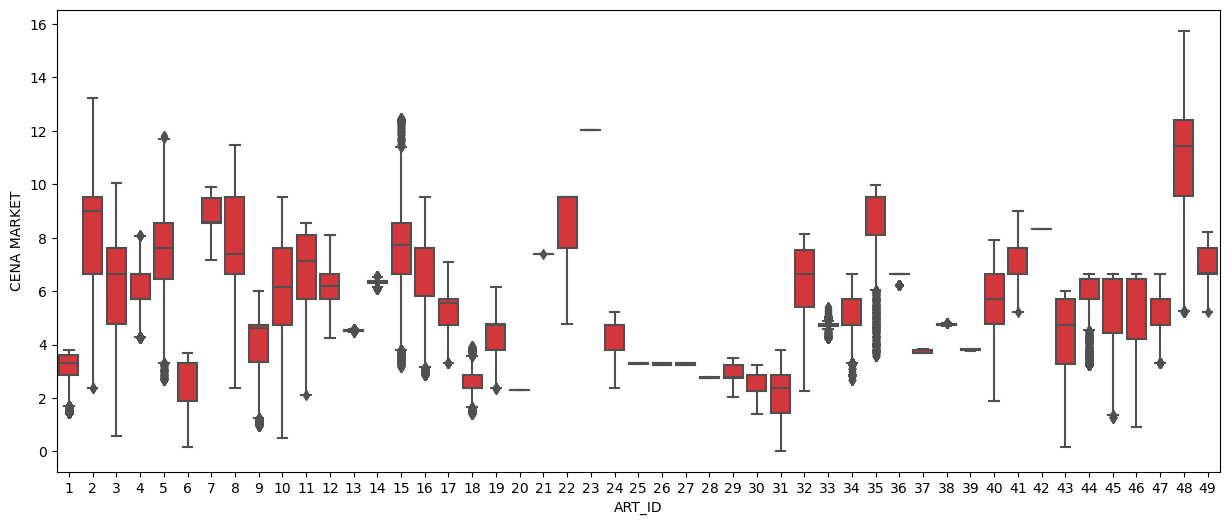

In [ ]:
filtered_df = df[df['ART_ID'] < 50]
plt.figure(figsize=(15, 6))
sns.boxplot(data=filtered_df, x="ART_ID", y="CENA_MARKET", palette=sns.color_palette(colors * len(filtered_df["ART_ID"].unique())))
plt.xlabel("ART_ID")
plt.ylabel("CENA MARKET")
plt.show()

In [ ]:
df.describe().T

count        mean         std     min      25%       50%  \
MARKET_ID    89277712.0  119.642269   69.127846  2.0000   58.000  118.0000   
GRUPA_ID     89277712.0   13.910693    8.134427  1.0000    5.000   14.0000   
ART_ID       89277712.0  348.548119  200.995705  1.0000  175.000  349.0000   
OBROT        89277712.0   17.559483   89.004489  0.0000    0.000    0.0000   
ILOSC        89277712.0    4.080637   26.659994  0.0000    0.000    0.0000   
CENA_MARKET  21030004.0    5.959987    3.713719  0.0193    3.665    4.7609   

               75%       max  
MARKET_ID    177.0    237.00  
GRUPA_ID      22.0     26.00  
ART_ID       522.0    697.00  
OBROT          0.0  10973.85  
ILOSC          0.0   6003.23  
CENA_MARKET    7.6     53.00

In [ ]:
df.isnull().sum()

DATA                  0
MARKET_ID             0
GRUPA_ID              0
ART_ID                0
OBROT                 0
ILOSC                 0
NAZWA                 0
CENA_MARKET    68247708
dtype: int64

In [ ]:
df.to_pickle('PICKLE/df_temp.pkl') #checkpoint

In [ ]:
df.shape

(89277712, 8)

### Łączenie tabel

In [ ]:
df = pd.read_pickle('PICKLE/df_temp.pkl')

In [ ]:
df = pd.merge(df, kalendarz, how='left', on='DATA')

In [ ]:
df = pd.merge(df, promo_ceny, how='left', on = ['DATA','ART_ID'])

In [ ]:
# Uzupełnienie cen

In [ ]:
df['CENA_MARKET'] = df['CENA_MARKET'].fillna(df['CENA_AP'])

In [ ]:
df['CENA_MARKET'] = np.where(df['CENA_MARKET'] > df['CENA_AP'], df['CENA_AP'], df['CENA_MARKET'])

In [ ]:
df.isnull().sum()

DATA                   0
MARKET_ID              0
GRUPA_ID               0
ART_ID                 0
OBROT                  0
ILOSC                  0
NAZWA                  0
CENA_MARKET      9559134
Nr_dn_tyg              0
Nr_dn_mies             0
Nr_mies                0
Nr_tyg                 0
Nr_rok                 0
Dn_handlowy            0
Hot_day                0
Hot_day_Xmass          0
Hot_day_Wlkn           0
CENA_NP          9559134
CENA_AP          9559134
PRZECENA         9559134
PROMO_KOD        9559134
dtype: int64

In [ ]:
df.dropna(how='any', inplace=True) # usunięcie wierszy dla których nie znaleziono ceny

In [ ]:
df = pd.merge(df, HICP, how='left', on = 'DATA')

In [ ]:
# Dopasowanie typów danych do poszczególnych kolumn
int32 = ['MARKET_ID', 'GRUPA_ID', 'ART_ID', 'PROMO_KOD']
df[int32] = df[int32].astype('int32')

In [ ]:
category = ['MARKET_ID', 'GRUPA_ID', 'ART_ID', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 'Nr_rok', 'Dn_handlowy', 'Hot_day', 'Hot_day_Xmass', 'Hot_day_Wlkn', 'PROMO_KOD']
df[category] = df[category].astype('category')

In [ ]:
float32 =['ILOSC', 'CENA_MARKET', 'CENA_AP', 'CENA_NP', 'PRZECENA', 'HICP']
df[float32] = df[float32].astype('float32')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79718578 entries, 0 to 79718577
Data columns (total 22 columns):
 #   Column         Dtype         
---  ------         -----         
 0   DATA           datetime64[ns]
 1   MARKET_ID      category      
 2   GRUPA_ID       category      
 3   ART_ID         category      
 4   OBROT          float64       
 5   ILOSC          float32       
 6   NAZWA          object        
 7   CENA_MARKET    float32       
 8   Nr_dn_tyg      category      
 9   Nr_dn_mies     category      
 10  Nr_mies        category      
 11  Nr_tyg         category      
 12  Nr_rok         category      
 13  Dn_handlowy    category      
 14  Hot_day        category      
 15  Hot_day_Xmass  category      
 16  Hot_day_Wlkn   category      
 17  CENA_NP        float32       
 18  CENA_AP        float32       
 19  PRZECENA       float32       
 20  PROMO_KOD      category      
 21  HICP           float32       
dtypes: category(13), datetime64[ns](1), floa

In [ ]:
df.rename(columns = {'ILOSC':'y'}, inplace = True)

In [ ]:
new_order = ['DATA', 'MARKET_ID', 'GRUPA_ID', 'ART_ID', 'NAZWA', 'CENA_NP', 'CENA_AP', 'PRZECENA', 'CENA_MARKET', 'OBROT', 'PROMO_KOD', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 'Nr_rok', 'Dn_handlowy', 'Hot_day', 'Hot_day_Xmass', 'Hot_day_Wlkn', 'HICP', 'y'] # Nowa kolejność kolumn
df = df.reindex(columns=new_order)

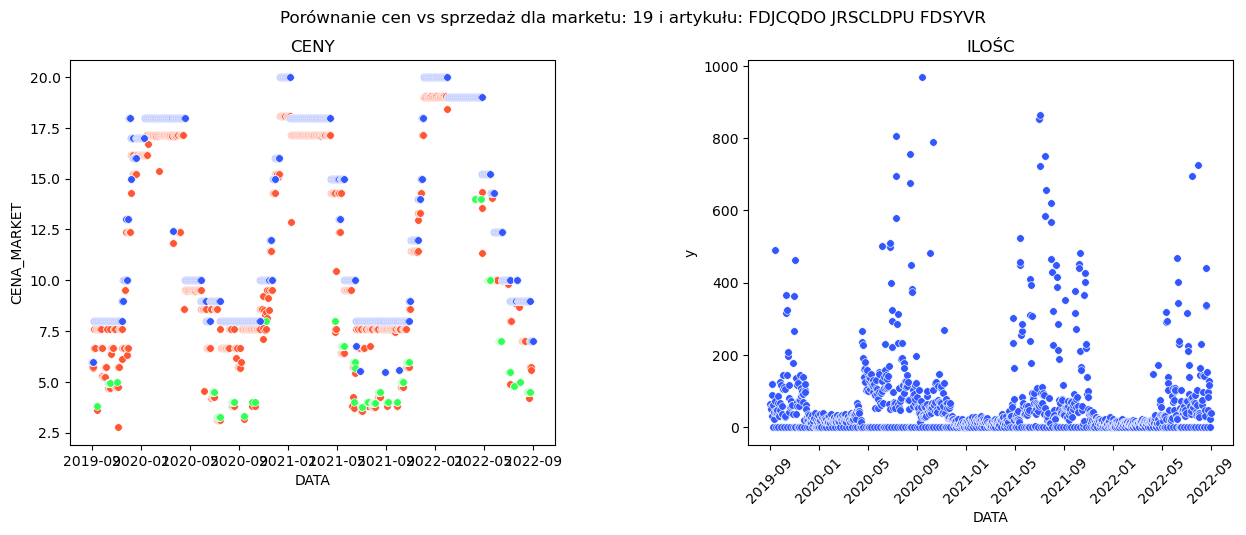

In [ ]:
ff.plot_cena(df, 19, 158)

Oczyszczone dane wyglądają następująco:

In [ ]:
df.head(3)

DATA MARKET_ID GRUPA_ID ART_ID                         NAZWA  CENA_NP  \
0 2019-09-02         2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
1 2019-09-03         2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
2 2019-09-04         2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   

   CENA_AP  PRZECENA  CENA_MARKET  OBROT PROMO_KOD Nr_dn_tyg Nr_dn_mies  \
0     3.49       0.0         3.49    0.0         0         1          2   
1     3.49       0.0         3.49    0.0         0         2          3   
2     3.49       0.0         3.49    0.0         0         3          4   

  Nr_mies Nr_tyg Nr_rok Dn_handlowy Hot_day Hot_day_Xmass Hot_day_Wlkn  \
0       9     36   2019           1       0             0            0   
1       9     36   2019           1       0             0            0   
2       9     36   2019           1       0             0            0   

         HICP    y  
0  105.199997  0.0  
1  105.199997  0.0  
2  105.199997  0.0

In [ ]:
df.describe().T

count       mean        std         min     25%         50%  \
CENA_NP      79718578.0   3.880406   5.734397    0.100000    4.49    5.990000   
CENA_AP      79718578.0   3.850663   5.692187    0.100000    4.49    5.990000   
PRZECENA     79718578.0   0.007868   0.052690    0.000000    0.00    0.000000   
CENA_MARKET  79718578.0   3.803628   5.621907    0.019300    3.99    5.990000   
OBROT        79718578.0  19.665058  93.969695    0.000000    0.00    0.000000   
HICP         79718578.0  52.634510  41.521702  105.199997  109.00  113.199997   
y            79718578.0   4.256569  27.676815    0.000000    0.00    0.000000   

                    75%           max  
CENA_NP        8.990000     55.919998  
CENA_AP        8.560000     55.919998  
PRZECENA       0.000000      0.841000  
CENA_MARKET    7.990929     55.919998  
OBROT          3.490000  10973.850000  
HICP         118.599998    131.399994  
y              1.000000   6003.229980

In [ ]:
df.to_pickle('PICKLE/df.pkl')

### Klasteryzacja

#### Przygotowanie danych

In [ ]:
df = pd.read_pickle('PICKLE/df.pkl')

In [ ]:
df_temp = df[['DATA', 'MARKET_ID', 'ART_ID', 'y', 'CENA_MARKET', 'PROMO_KOD']].copy() #kopia dataframe'u
df_temp = df_temp.loc[df['DATA'] >= '2021-09-01']
mask = df['PROMO_KOD']==0 #tworzenie maski

df_temp.loc[mask, 'ILOSC_NIEPROMO'] = df_temp.loc[mask, 'y'] #wydzielenie danych względem maski
df_temp.loc[mask, 'CENA_NIEPROMO'] = df_temp.loc[mask, 'CENA_MARKET']
df_temp.loc[~mask, 'ILOSC_PROMO'] = df_temp.loc[~mask, 'y']
df_temp.loc[~mask, 'CENA_PROMO'] = df_temp.loc[~mask, 'CENA_MARKET']

df_temp.drop(['DATA', 'ART_ID', 'y','CENA_MARKET'], axis=1, inplace=True) #usunięcienie niepotrzebnych kolumn

df_k = df_temp.groupby(['MARKET_ID'])[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']].agg(np.nanmean)

df_k['ILOSC_NIEPROMO'] = df_k['ILOSC_NIEPROMO'] / df_k['ILOSC_NIEPROMO'].max()  #Normalizacja min-mix
df_k['ILOSC_PROMO'] = df_k['ILOSC_PROMO'] / df_k['ILOSC_PROMO'].max() 
df_k['CENA_NIEPROMO'] = df_k['CENA_NIEPROMO'] / df_k['CENA_NIEPROMO'].max() 
df_k['CENA_PROMO'] = df_k['CENA_PROMO'] / df_k['CENA_PROMO'].max() 
df_k2 = df_k.copy()

#### Elbow method

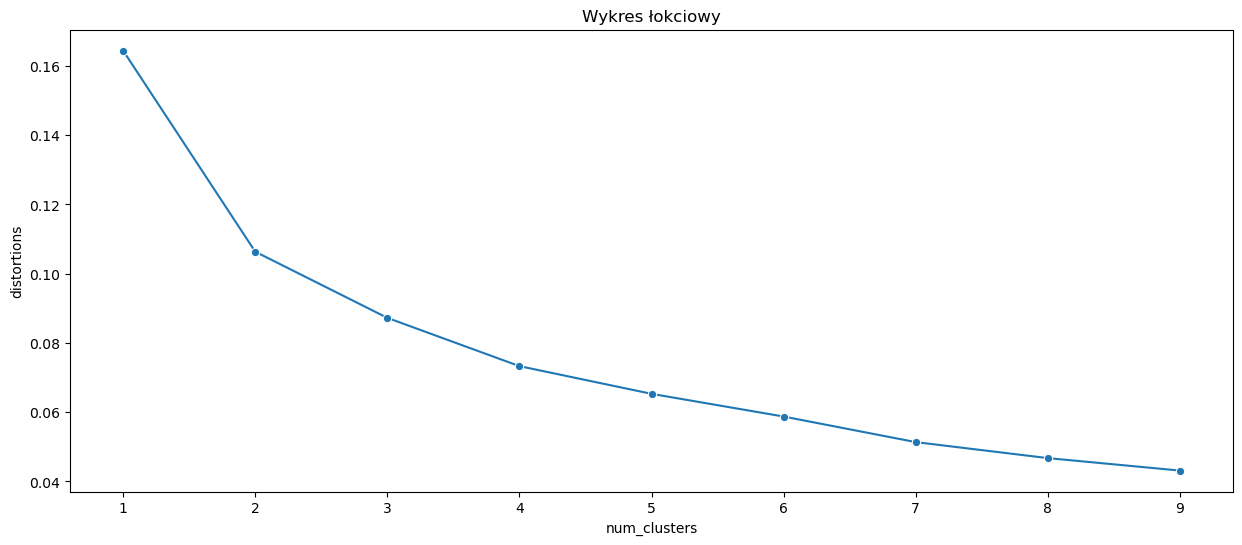

In [ ]:
distortions = []
num_clusters = range(1, 10)

# Utwórz listę zniekształceń z funkcji kmeans
for i in num_clusters:
    cluster_centers, distortion = kmeans(df_k[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']], i)
    distortions.append(distortion)

# Utwórz ramkę danych DataFrame z dwiema listami - num_clusters i distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})

# Utwórz wykres liniowy num_clusters i distortions
plt.figure(figsize=(15, 6))
sns.lineplot(data=elbow_plot, x='num_clusters', y='distortions', marker='o')
plt.xticks(num_clusters)
plt.title('Wykres łokciowy')
plt.show()

####  KMeans Clustering

In [ ]:
cluster_centers, distortion = kmeans(df_k[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']], 5)
df_k['CLUSTER_LABELS'], distortion_list = vq(df_k[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']], cluster_centers )

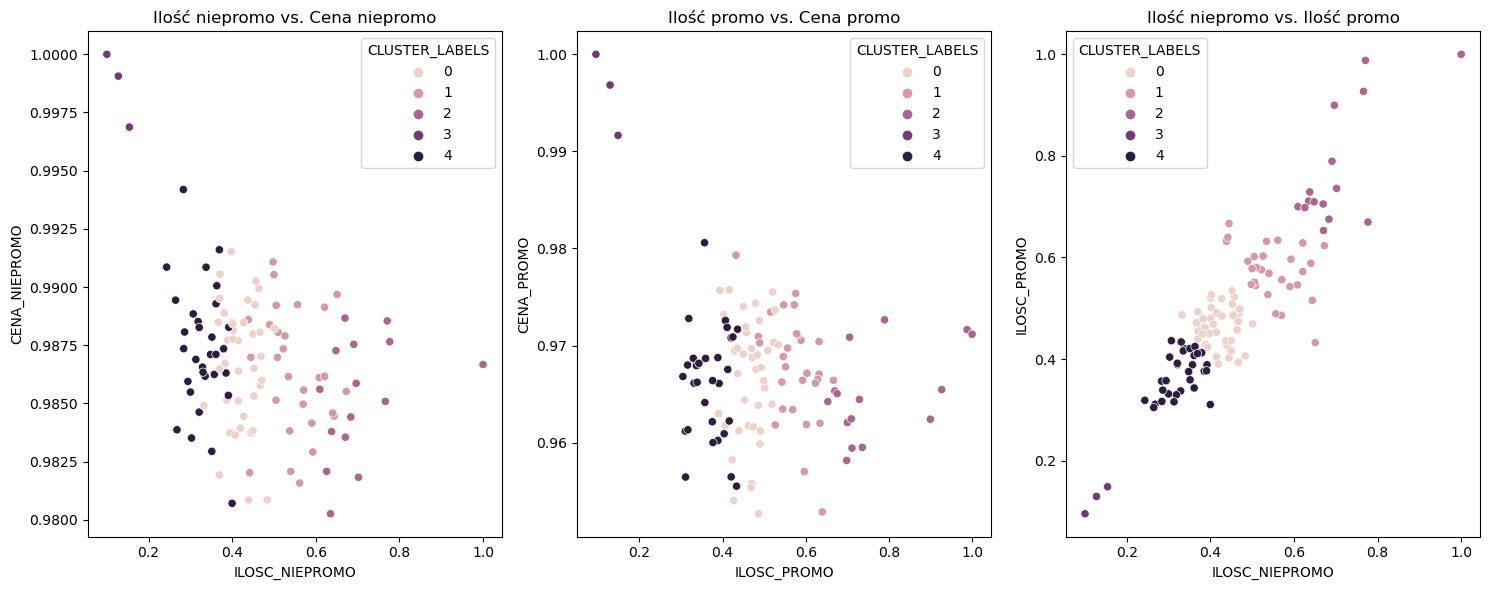

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(15, 6))
sns.scatterplot(x='ILOSC_NIEPROMO', y='CENA_NIEPROMO', hue='CLUSTER_LABELS', data=df_k, ax=axes[0])
axes[0].set_title('Ilość niepromo vs. Cena niepromo')
sns.scatterplot(x='ILOSC_PROMO', y='CENA_PROMO', hue='CLUSTER_LABELS', data=df_k, ax=axes[1])
axes[1].set_title('Ilość promo vs. Cena promo')
sns.scatterplot(x='ILOSC_NIEPROMO', y='ILOSC_PROMO', hue='CLUSTER_LABELS', data=df_k, ax=axes[2])
axes[2].set_title('Ilość niepromo vs. Ilość promo')
plt.tight_layout()
plt.show()

#### Hierarchical clustering

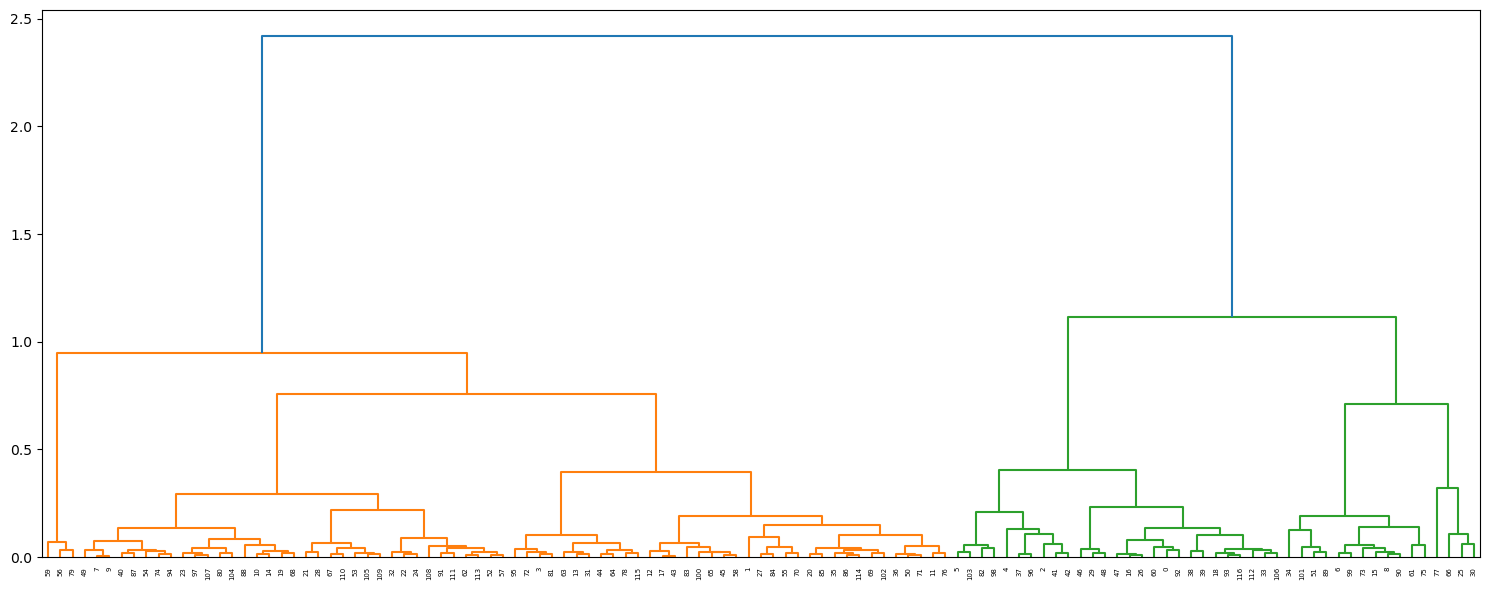

In [ ]:
distance_matrix = linkage(df_k2[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']], method='ward', metric= 'euclidean')
fig, ax = plt.subplots(figsize=(15, 6))
dn = dendrogram(distance_matrix, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
num_clusters = 3
clustering_model = AgglomerativeClustering(n_clusters=num_clusters)
clustering_model.fit(df_k2[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']])

# Przypisanie etykiet klastrów do danych
df_k2['CLUSTER'] = clustering_model.labels_

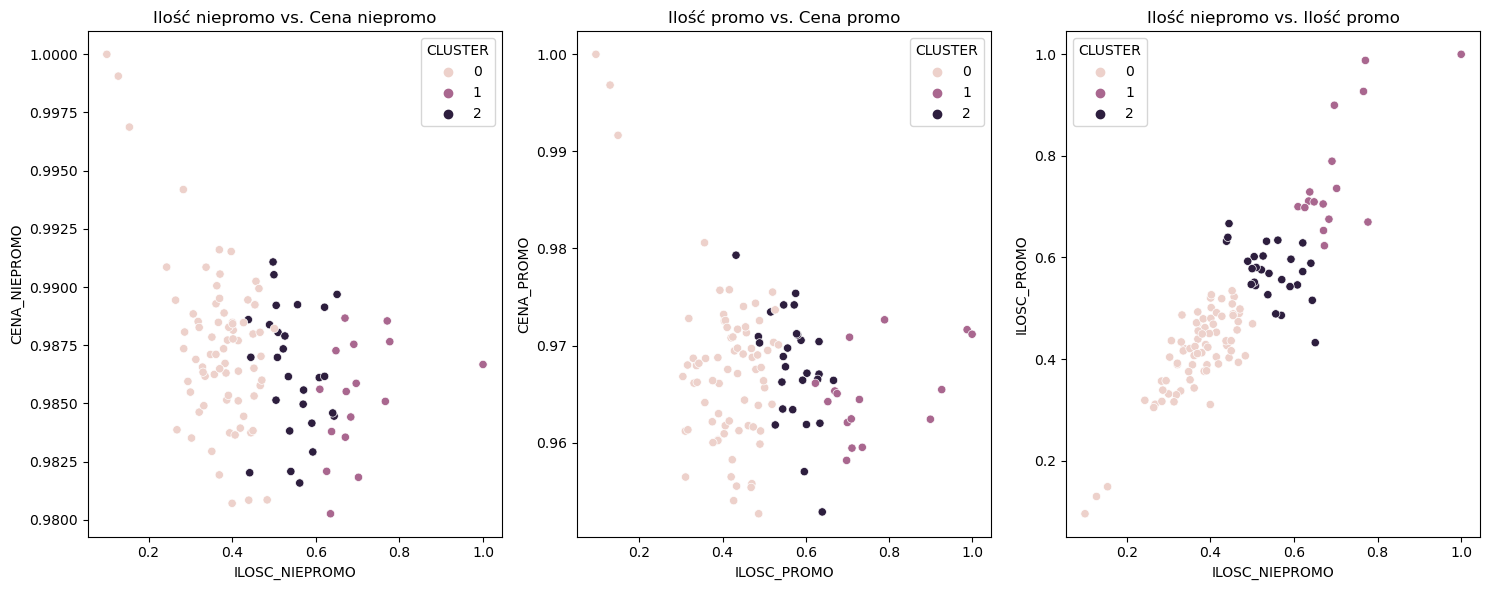

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(15, 6))
sns.scatterplot(x='ILOSC_NIEPROMO', y='CENA_NIEPROMO', hue='CLUSTER', data = df_k2, ax=axes[0])
axes[0].set_title('Ilość niepromo vs. Cena niepromo')
sns.scatterplot(x='ILOSC_PROMO', y='CENA_PROMO', hue='CLUSTER', data = df_k2, ax=axes[1])
axes[1].set_title('Ilość promo vs. Cena promo')
sns.scatterplot(x='ILOSC_NIEPROMO', y='ILOSC_PROMO', hue='CLUSTER', data = df_k2, ax=axes[2])
axes[2].set_title('Ilość niepromo vs. Ilość promo')
plt.tight_layout()
plt.show()

In [ ]:
df_k2.drop(['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO'], axis=1, inplace=True)

In [ ]:
df = df.merge(df_k2, on='MARKET_ID', how='left')

In [ ]:
df.head(3)

DATA MARKET_ID GRUPA_ID ART_ID                         NAZWA  CENA_NP  \
0 2019-09-02         2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
1 2019-09-03         2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
2 2019-09-04         2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   

   CENA_AP  PRZECENA  CENA_MARKET  OBROT PROMO_KOD Nr_dn_tyg Nr_dn_mies  \
0     3.49       0.0         3.49    0.0         0         1          2   
1     3.49       0.0         3.49    0.0         0         2          3   
2     3.49       0.0         3.49    0.0         0         3          4   

  Nr_mies Nr_tyg Nr_rok Dn_handlowy Hot_day Hot_day_Xmass Hot_day_Wlkn  \
0       9     36   2019           1       0             0            0   
1       9     36   2019           1       0             0            0   
2       9     36   2019           1       0             0            0   

         HICP    y  CLUSTER  
0  105.199997  0.0        2  
1  105.199997  0.0        2  
2  105.199997  0.0        2

In [ ]:
df_temp = df.groupby(['DATA', 'ART_ID', 'CLUSTER']).agg({
                                                    'OBROT':'sum',
                                                    'y':'sum'
                                                   }).reset_index()

In [ ]:
df_temp['CENA_MARKET'] = df_temp['OBROT'] / df_temp['y']
#df.loc[df['CENA_MARKET'] == 0, 'CENA_MARKET'] = np.nan
#df['CENA_MARKET'] = df.groupby(['ART_ID', 'MARKET_ID'])['CENA_MARKET'].fillna(method='ffill').fillna(method='ffill')
#df['CENA_MARKET'] = df.groupby(['ART_ID', 'MARKET_ID'])['CENA_MARKET'].fillna(method='ffill').fillna(method='bfill')

In [ ]:
df = df.drop(['MARKET_ID', 'OBROT', 'y', 'CENA_MARKET', 'CLUSTER'], axis=1)
df.drop_duplicates(inplace=True)

In [ ]:
df = pd.merge(df_temp, df, how='left', on=['DATA', 'ART_ID'])

In [ ]:
df['CENA_MARKET'] = df['CENA_MARKET'].fillna(df['CENA_AP'])
df['CENA_MARKET'] = np.where(df['CENA_MARKET'] > df['CENA_AP'], df['CENA_AP'], df['CENA_MARKET'])

In [ ]:
df.isnull().sum()

DATA                  0
ART_ID                0
CLUSTER               0
OBROT                 0
y                     0
CENA_MARKET      245106
GRUPA_ID         245106
NAZWA            245106
CENA_NP          245106
CENA_AP          245106
PRZECENA         245106
PROMO_KOD        245106
Nr_dn_tyg        245106
Nr_dn_mies       245106
Nr_mies          245106
Nr_tyg           245106
Nr_rok           245106
Dn_handlowy      245106
Hot_day          245106
Hot_day_Xmass    245106
Hot_day_Wlkn     245106
HICP             245106
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.head()

DATA ART_ID  CLUSTER   OBROT           y  CENA_MARKET GRUPA_ID  \
0 2019-09-02      1        0  190.46   73.000000     2.609041       19   
1 2019-09-02      1        1   53.14   16.000000     3.321250       19   
2 2019-09-02      1        2   68.77   23.000000     2.990000       19   
3 2019-09-02      2        0  624.58  111.639999     5.594590        8   
4 2019-09-02      2        1  473.01   86.529999     5.466428        8   

                          NAZWA  CENA_NP  CENA_AP  PRZECENA PROMO_KOD  \
0  FCHKWROVC QD JROULRGU FDSYVR     3.49     3.49       0.0         0   
1  FCHKWROVC QD JROULRGU FDSYVR     3.49     3.49       0.0         0   
2  FCHKWROVC QD JROULRGU FDSYVR     3.49     3.49       0.0         0   
3                   JHSDL ERSCR     5.99     5.99       0.0         0   
4                   JHSDL ERSCR     5.99     5.99       0.0         0   

  Nr_dn_tyg Nr_dn_mies Nr_mies Nr_tyg Nr_rok Dn_handlowy Hot_day  \
0         1          2       9     36   2019           1       0   
1         1          2       9     36   2019           1       0   
2         1          2       9     36   2019           1       0   
3         1          2       9     36   2019           1       0   
4         1          2       9     36   2019           1       0   

  Hot_day_Xmass Hot_day_Wlkn        HICP  
0             0            0  105.199997  
1             0            0  105.199997  
2             0            0  105.199997  
3             0            0  105.199997  
4             0            0  105.199997

In [ ]:
df.shape

(2041254, 22)

In [ ]:
new_order = ['DATA', 'CLUSTER', 'GRUPA_ID', 'ART_ID', 'NAZWA', 'CENA_NP', 'CENA_AP', 'PRZECENA', 'CENA_MARKET', 'PROMO_KOD', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 'Nr_rok', 'Dn_handlowy', 'Hot_day', 'Hot_day_Xmass', 'Hot_day_Wlkn', 'HICP', 'y'] 
df = df.reindex(columns=new_order)

In [ ]:
df.to_pickle('PICKLE/df_3.pkl') #checkpoint

## EDA

### Import

In [ ]:
df = pd.read_pickle('PICKLE/df_3.pkl')
df['TYDZIEN'] = df['DATA'].dt.to_period('W').dt.to_timestamp()

In [ ]:
df.head(5)

DATA  CLUSTER GRUPA_ID ART_ID                         NAZWA  CENA_NP  \
0 2019-09-02        0       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
1 2019-09-02        1       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
2 2019-09-02        2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
3 2019-09-02        0        8      2                   JHSDL ERSCR     5.99   
4 2019-09-02        1        8      2                   JHSDL ERSCR     5.99   

   CENA_AP  PRZECENA  CENA_MARKET PROMO_KOD Nr_dn_tyg Nr_dn_mies Nr_mies  \
0     3.49       0.0     2.609041         0         1          2       9   
1     3.49       0.0     3.321250         0         1          2       9   
2     3.49       0.0     2.990000         0         1          2       9   
3     5.99       0.0     5.594590         0         1          2       9   
4     5.99       0.0     5.466428         0         1          2       9   

  Nr_tyg Nr_rok Dn_handlowy Hot_day Hot_day_Xmass Hot_day_Wlkn        HICP  \
0     36   2019           1       0             0            0  105.199997   
1     36   2019           1       0             0            0  105.199997   
2     36   2019           1       0             0            0  105.199997   
3     36   2019           1       0             0            0  105.199997   
4     36   2019           1       0             0            0  105.199997   

            y    TYDZIEN  
0   73.000000 2019-09-02  
1   16.000000 2019-09-02  
2   23.000000 2019-09-02  
3  111.639999 2019-09-02  
4   86.529999 2019-09-02

### Opis danych

DataFrame prezentuje dane dotyczące sprzedaży różnych artykułów spożywczych w określonym dniu na przestrzeni 3 lat. Kolumny zawierają następujące informacje:

**ART_ID**: data sprzedaży (np. 2019-09-02),  
**CLUSTER_LABELS**: unikalne ID klastra który reprezentuje grupę marketów o podobnej charakterystyce sprzedaży (np. 1, 2),  
**GRUPA_ID**: określa przynależność produktu do danej kategorii (np. 2, 19),  
**NAZWA**: nazwa artykułu (np. "PIECZARKI DO MARYNATY POLSKA", "MELON GALIA"),  
**CENA_MARKET**: cena produktu na rynku (np. 3.026236, 5.573676),  #POPRAWIĆ
**CENA_SIEC**: cena produktu w sieci handlowej (np. 3.3250, 5.7442),  #POPRAWIĆ
**PROMO_KOD**: kod promocji dla produktu (np. 0, 13.0),  
**CENA_STANDARD**: standardowa cena produktu (np. 3.3250, 5.7442),  
**Nr_dn_tyg**: numer dnia tygodnia (np. 1, 2),  
**Nr_dn_mies**: numer dnia miesiąca (np. 2, 9),  
**Nr_mies**: numer miesiąca (np. 9),  
**Nr_tyg**: numer tygodnia (np. 36),  
**Nr_rok**: numer roku (np. 2019),  
**Dn_handlowy**: dzień handlowy (np. 1, 0),  
**Hot_day**: gorący dzień (np. 0, 1),  
**Hot_day_Xmass**: gorący dzień przed Bożym Narodzeniem (np. 0, 1),  
**Hot_day_Wlkn**: gorący dzień przed Wielkanocą (np. 0, 1),  
**HICP**: wskaźnik cen towarów i usług konsumpcyjnych (np. 105.2),  
**y**: ilość sprzedanych sztuk danego artykułu (np. 0, 2).

### Analiza sprzedaży i sezonowości

In [ ]:
df.head()

DATA  CLUSTER GRUPA_ID ART_ID                         NAZWA  CENA_NP  \
0 2019-09-02        0       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
1 2019-09-02        1       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
2 2019-09-02        2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
3 2019-09-02        0        8      2                   JHSDL ERSCR     5.99   
4 2019-09-02        1        8      2                   JHSDL ERSCR     5.99   

   CENA_AP  PRZECENA  CENA_MARKET PROMO_KOD Nr_dn_tyg Nr_dn_mies Nr_mies  \
0     3.49       0.0     2.609041         0         1          2       9   
1     3.49       0.0     3.321250         0         1          2       9   
2     3.49       0.0     2.990000         0         1          2       9   
3     5.99       0.0     5.594590         0         1          2       9   
4     5.99       0.0     5.466428         0         1          2       9   

  Nr_tyg Nr_rok Dn_handlowy Hot_day Hot_day_Xmass Hot_day_Wlkn        HICP  \
0     36   2019           1       0             0            0  105.199997   
1     36   2019           1       0             0            0  105.199997   
2     36   2019           1       0             0            0  105.199997   
3     36   2019           1       0             0            0  105.199997   
4     36   2019           1       0             0            0  105.199997   

            y    TYDZIEN  
0   73.000000 2019-09-02  
1   16.000000 2019-09-02  
2   23.000000 2019-09-02  
3  111.639999 2019-09-02  
4   86.529999 2019-09-02

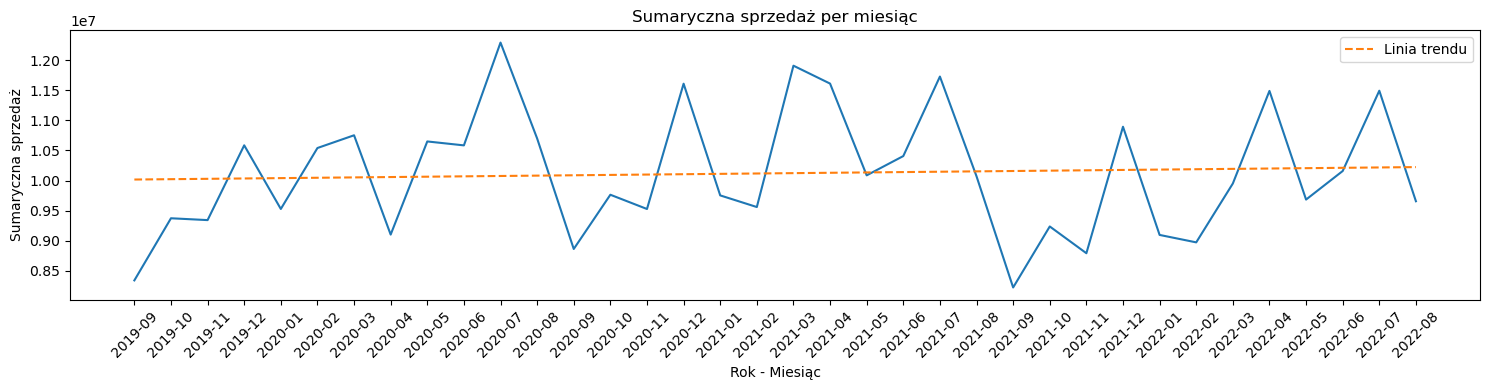

In [ ]:
# Agregacja danych
df['Rok-Miesiąc'] = df['DATA'].apply(lambda x: x.strftime('%Y-%m'))
monthly_sales = df.groupby('Rok-Miesiąc')['y'].sum().reset_index()
#monthly_sales = monthly_sales.loc[monthly_sales['Rok-Miesiąc'] < '2022-09']
# Wykres
plt.figure(figsize=(15, 4))
sns.lineplot(data=monthly_sales, x='Rok-Miesiąc', y='y')
# Obliczenie linii trendu
x = np.arange(len(monthly_sales['Rok-Miesiąc']))
y = monthly_sales['y']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# Dodanie linii trendu do wykresu
plt.plot(monthly_sales['Rok-Miesiąc'], p(x), linestyle='--', label='Linia trendu')
plt.title('Sumaryczna sprzedaż per miesiąc')
plt.xlabel('Rok - Miesiąc')
plt.ylabel('Sumaryczna sprzedaż')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

**Obserwacja**: Na wykresie widać, że istnieje nieznaczny trend wzrostowy dla sumarycznej sprzedaży.

In [ ]:
df.head(3)

DATA  CLUSTER GRUPA_ID ART_ID                         NAZWA  CENA_NP  \
0 2019-09-02        0       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
1 2019-09-02        1       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
2 2019-09-02        2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   

   CENA_AP  PRZECENA  CENA_MARKET PROMO_KOD Nr_dn_tyg Nr_dn_mies Nr_mies  \
0     3.49       0.0     2.609041         0         1          2       9   
1     3.49       0.0     3.321250         0         1          2       9   
2     3.49       0.0     2.990000         0         1          2       9   

  Nr_tyg Nr_rok Dn_handlowy Hot_day Hot_day_Xmass Hot_day_Wlkn        HICP  \
0     36   2019           1       0             0            0  105.199997   
1     36   2019           1       0             0            0  105.199997   
2     36   2019           1       0             0            0  105.199997   

      y    TYDZIEN Rok-Miesiąc  
0  73.0 2019-09-02     2019-09  
1  16.0 2019-09-02     2019-09  
2  23.0 2019-09-02     2019-09

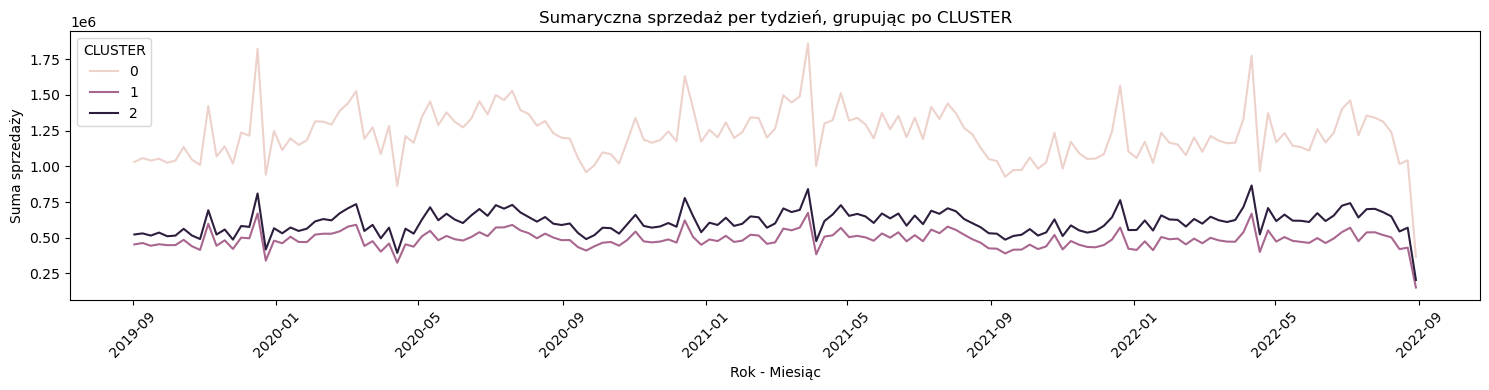

In [ ]:
# Grupowanie danych i obliczenie sumy sprzedaży dla każdej CLUSTER na tydzień
df_grouped = df.groupby(['TYDZIEN', 'CLUSTER']).agg({'y': 'sum'}).reset_index()

# Wykres sprzedaży w agregacji per cluster / grupę makretów
plt.figure(figsize=(15, 4))
sns.lineplot(data=df_grouped, x='TYDZIEN', y='y', hue='CLUSTER')
plt.title('Sumaryczna sprzedaż per tydzień, grupując po CLUSTER')
plt.xlabel('Rok - Miesiąc')
plt.ylabel('Suma sprzedaży')
plt.legend(title='CLUSTER', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Obserwacja**: Wykresy liniowe na poszczególnych grup marketów (CLUSTER_LABELS) wykazują bardzo zbliżoną "charakterystykę" to znaczy przebieg wykresu jest dla wszystkich grup jest bardzo podobny, jedynie wykresy są przesunięte na osi Y. Klaster '1' tworzy część marketów otwartych w 2021 stąd dane zaczynające się od 3 kwartału 2021.

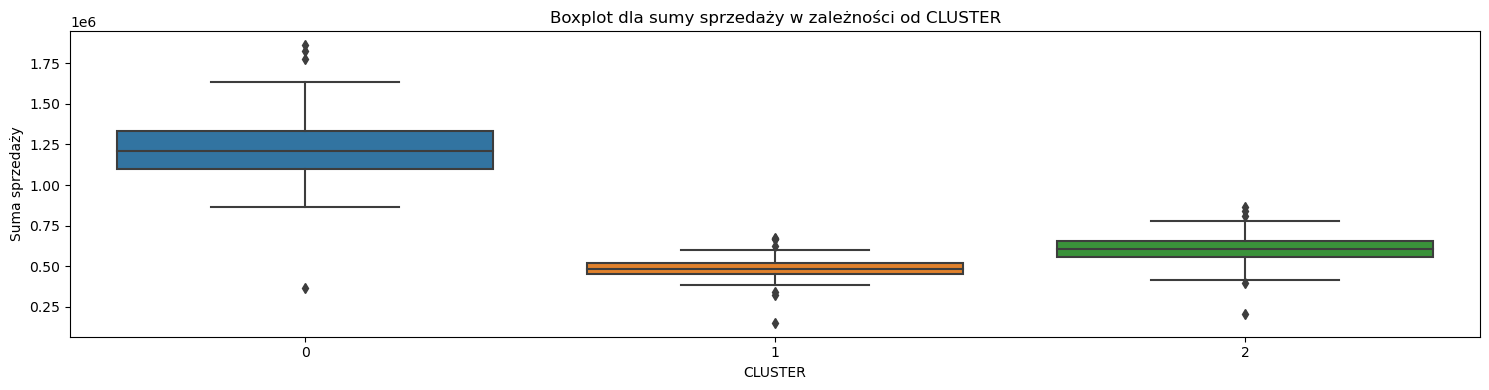

In [ ]:
# Grupowanie danych i obliczenie sumy sprzedaży dla każdej CLUSTER_LABELS na tydzień
df_grouped = df.groupby(['TYDZIEN', 'CLUSTER']).agg({'y': 'sum'}).reset_index()

# Tworzenie boxplot
plt.figure(figsize=(15, 4))
sns.boxplot(data=df_grouped, x='CLUSTER', y='y')
plt.title('Boxplot dla sumy sprzedaży w zależności od CLUSTER')
plt.xlabel('CLUSTER')
plt.ylabel('Suma sprzedaży')
plt.tight_layout()
plt.show()

In [ ]:
%%capture
# Grupowanie danych i obliczenie sumy sprzedaży dla każdej GRUPA_ID per tydzień
df_grouped = df.groupby(['TYDZIEN', 'GRUPA_ID']).agg({'y': 'sum'}).reset_index()

# Ograniczenie wykresu do 5 grup z największą sprzedażą
top5_grupa_id = df_grouped.groupby('GRUPA_ID').agg({'y': 'sum'}).nlargest(5, 'y').index
df_top5 = df_grouped[df_grouped['GRUPA_ID'].isin(top5_grupa_id)]
df_top5['GRUPA_ID'] = df_top5['GRUPA_ID'].astype('int32')
df_top5['GRUPA_ID'] = df_top5['GRUPA_ID'].astype('category')

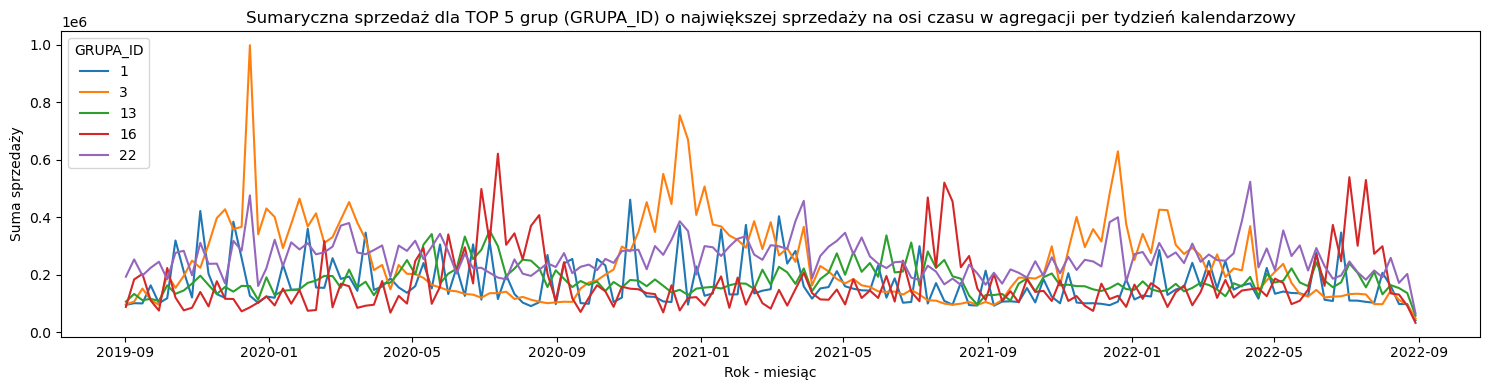

In [ ]:
# Wykres sprzedaży w agregacji grupa artykułów 
plt.figure(figsize=(15, 4))
sns.lineplot(data=df_top5, x='TYDZIEN', y='y', hue='GRUPA_ID', legend='auto')
plt.title('Sumaryczna sprzedaż dla TOP 5 grup (GRUPA_ID) o największej sprzedaży na osi czasu w agregacji per tydzień kalendarzowy')
plt.xlabel('Rok - miesiąc')
plt.ylabel('Suma sprzedaży')
plt.legend([1, 3, 13, 16, 22], title='GRUPA_ID', loc='upper left')
plt.tight_layout()
plt.show()

**Obserwacja**: Na wykresie widać dużą zmienność tydzień do tygodnia oraz peak'i sprzedażowe (na tym etapie ciężko określić co wpływa na tą zmienność. Dla GRUPA_ID o numerze 3 dodatkowo można z wykresu odczytać sezonowość roczną.

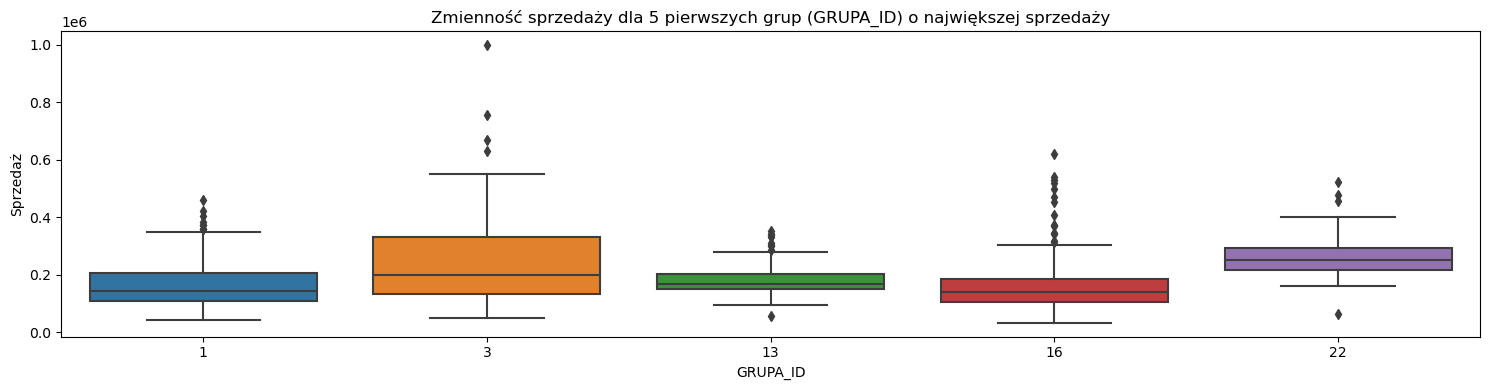

In [ ]:
# Boxplot pokazujący zmienność sprzedaży:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df_top5, x='GRUPA_ID', y='y')
plt.title('Zmienność sprzedaży dla 5 pierwszych grup (GRUPA_ID) o największej sprzedaży')
plt.xlabel('GRUPA_ID')
plt.ylabel('Sprzedaż')
plt.tight_layout()
plt.show()

Ponieważ na wykresie widać sezonowość warto wykonać dekompozycję sezonowości.

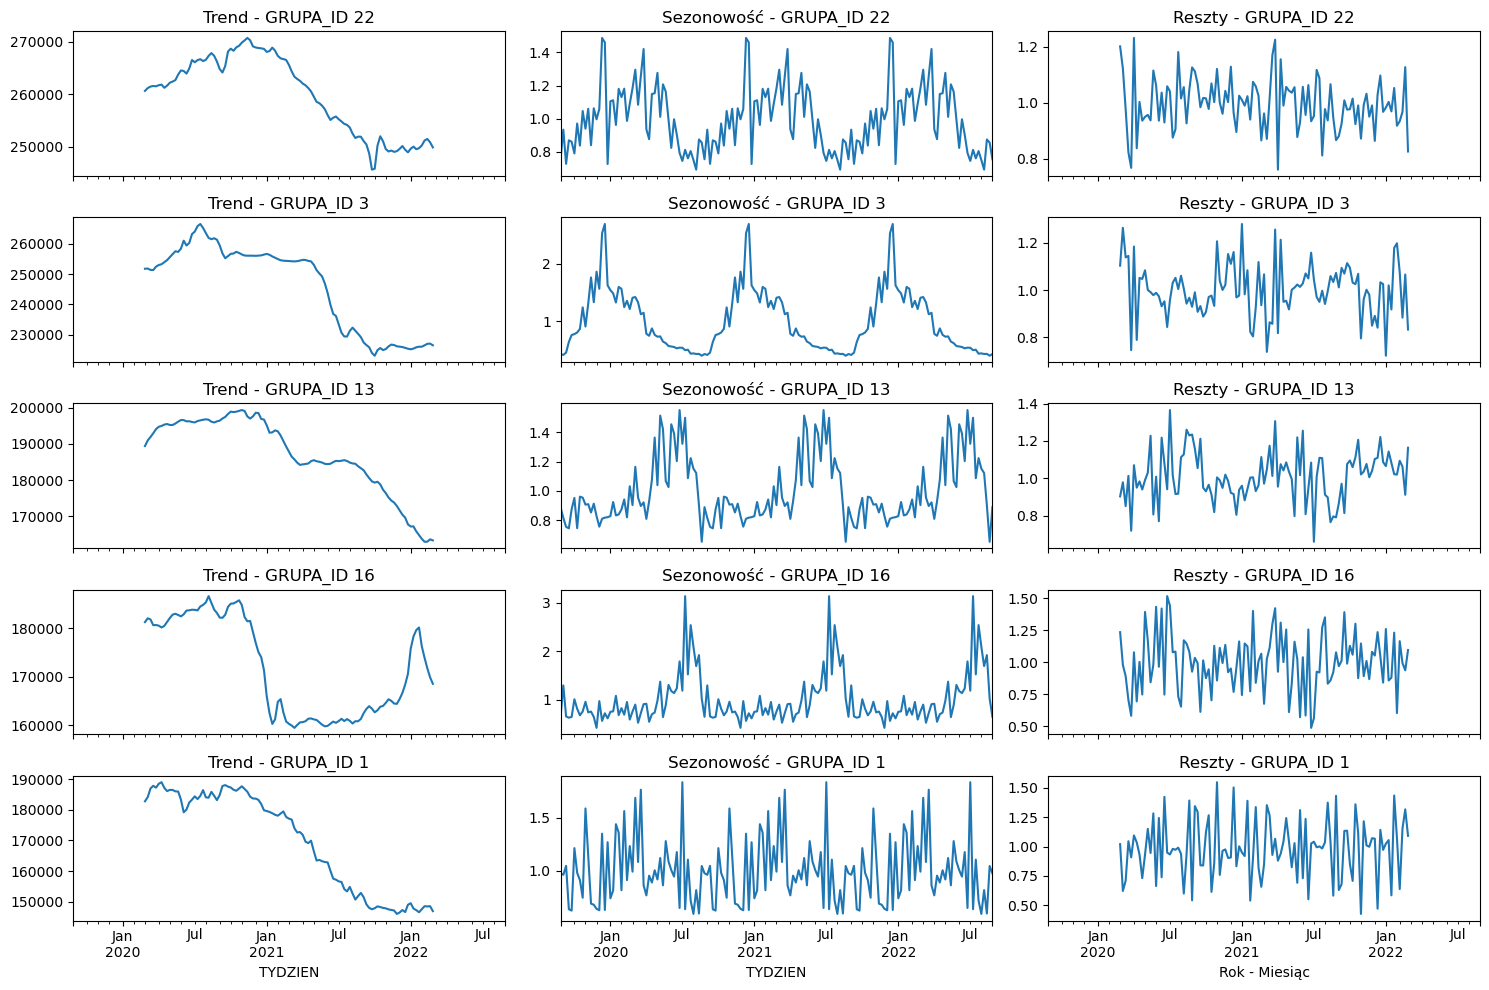

In [ ]:
# Grupowanie danych i obliczenie sumy sprzedaży per tydzień
df_grouped_total = df.groupby(['TYDZIEN']).agg({'y': 'sum'}).reset_index()
df_grouped_total = df_grouped_total.set_index('TYDZIEN')

fig, axes = plt.subplots(len(top5_grupa_id), 3, figsize=(15, 2 * len(top5_grupa_id)), sharex=True)
for i, grupa_id in enumerate(top5_grupa_id):
    df_group = df_top5[df_top5['GRUPA_ID'] == grupa_id].set_index('TYDZIEN')
    # Dekompozycja sezonowości
    result = seasonal_decompose(df_group['y'], model='multiplicative', period=52)  # Ustalamy okres na 52 tygodnie (1 rok)
    # Wykres dekompozycji sezonowości dla danej grupy
    #result.plot()
    result.trend.plot(ax=axes[i, 0], title=f'Trend - GRUPA_ID {grupa_id}')
    result.seasonal.plot(ax=axes[i, 1], title=f'Sezonowość - GRUPA_ID {grupa_id}')
    result.resid.plot(ax=axes[i, 2], title=f'Reszty - GRUPA_ID {grupa_id}')
plt.xlabel('Rok - Miesiąc')
plt.tight_layout()
plt.show()

**Obserwacja**: Na wykresach widać, że różne grupy wykazują różne trendy i różną sezonowość. Obserwacja zgadza się z życiową intuicją tzn. istnieje wiele produktów, których wolumen sprzedaży determinuje popyt (cena za którą konsumenci chcą kupić) oraz podaż (np ze względu na sezonową produkcję artykułów rolnospożywczych).

In [ ]:
# Agregacja danych
df['Rok-Miesiąc'] = df['DATA'].apply(lambda x: x.strftime('%Y-%m'))
top10_articles = df.groupby(['ART_ID', 'GRUPA_ID', 'NAZWA'])['y'].sum().nlargest(10).reset_index()
top10_articles['NAZWA_GRUPA'] = top10_articles['NAZWA'] + ' (Grupa: ' + top10_articles['GRUPA_ID'].astype(str) + ')'
df['NAZWA_GRUPA'] = df['NAZWA'] + ' (Grupa: ' + df['GRUPA_ID'].astype(str) + ')'
top10_articles_df = df[df['ART_ID'].isin(top10_articles['ART_ID'])].groupby(['Rok-Miesiąc', 'ART_ID', 'NAZWA_GRUPA'])['y'].sum().reset_index()


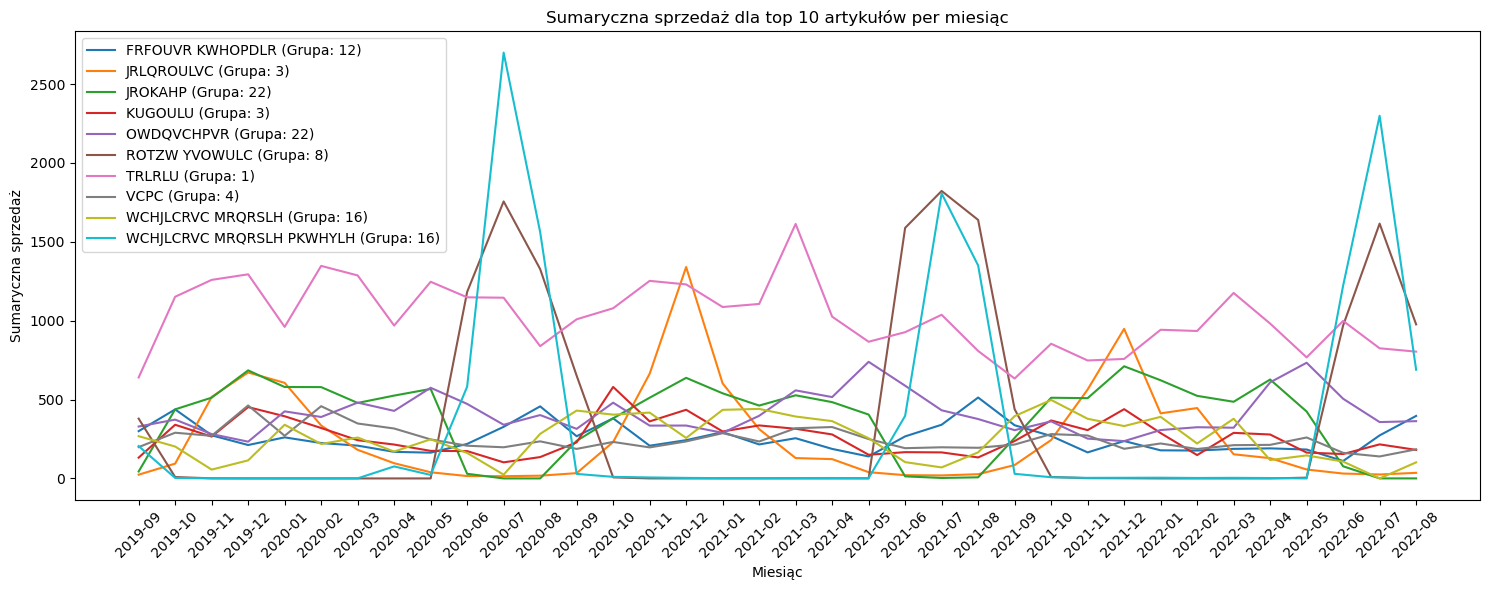

In [ ]:
# Wykres
plt.figure(figsize=(15, 4))
sns.lineplot(data=top10_articles_df, x='Rok-Miesiąc', y='y', hue='NAZWA_GRUPA', legend='auto', ci=None)
plt.title('Sumaryczna sprzedaż dla top 10 artykułów per miesiąc')
plt.xlabel('Miesiąc')
plt.ylabel('Sumaryczna sprzedaż')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

**Obserwacja**: Na wykresie widać, że istnieją 2 artykuły z TOP10, które wykazują bardzo mocną sezonowość roczną w okresie letnim oraz 1 artykuł. z mocną sezonowością zimową - peak'iem sprzedaży w grudniu.

### Analiza wpływu promocji na ceny i sprzedaż

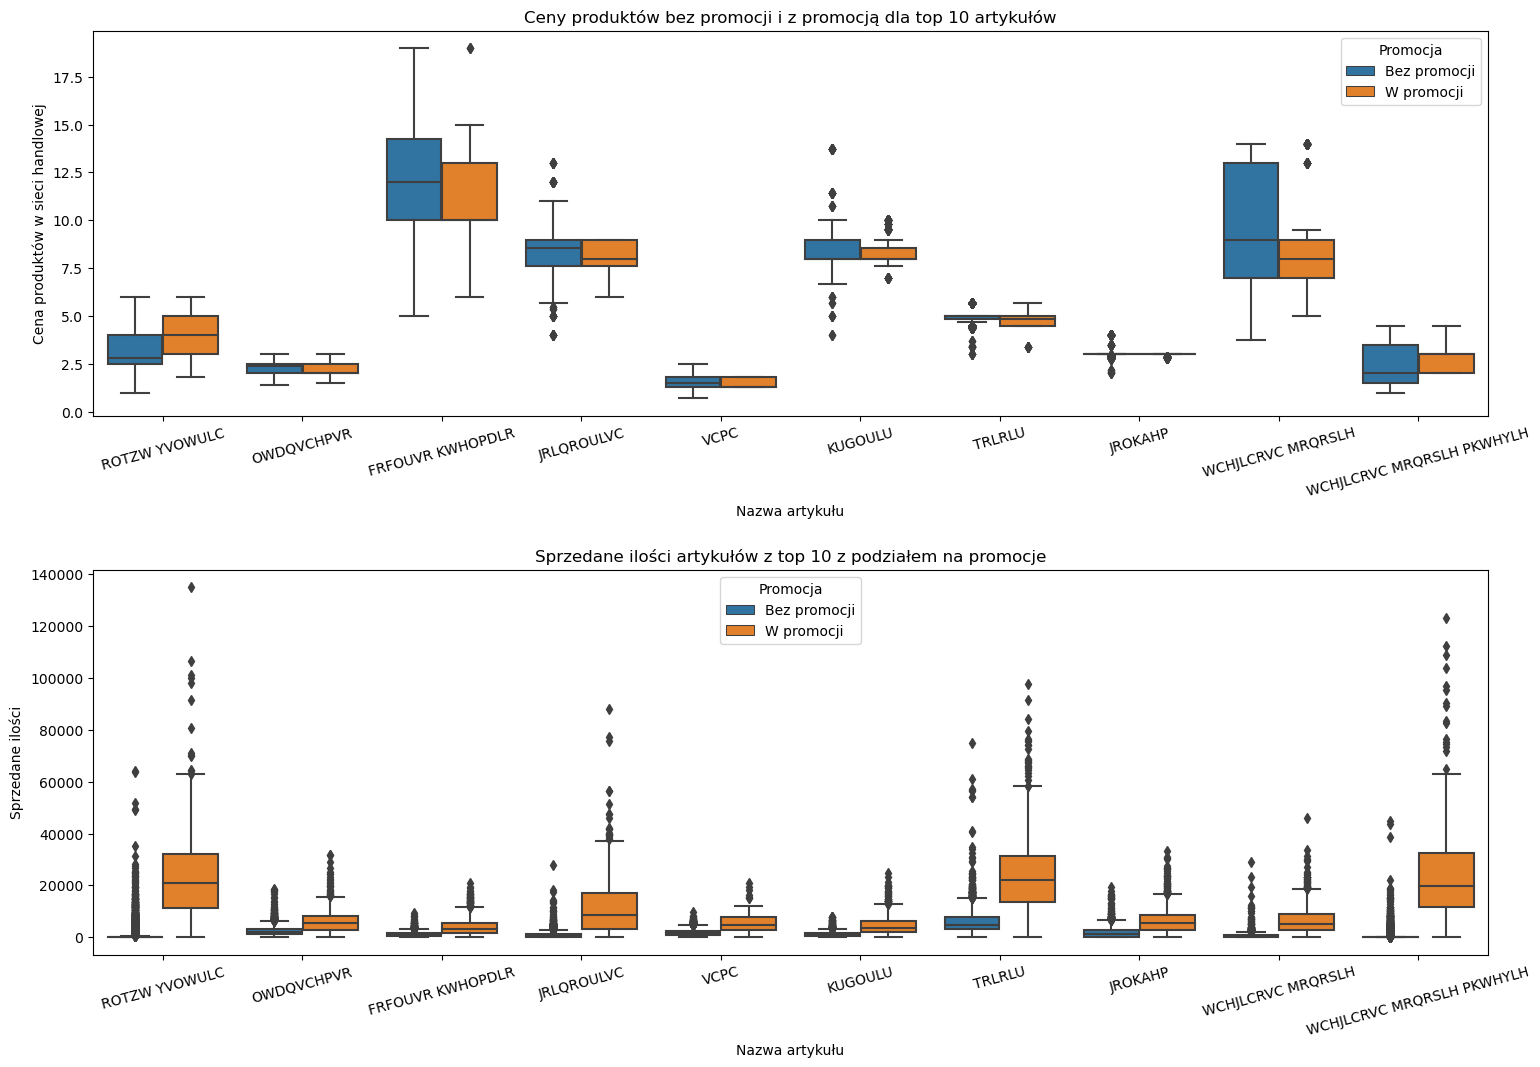

In [ ]:
# Wyznacz top 10 artykułów z największą sprzedażą
top10_art = df.groupby('ART_ID').agg({'y': 'sum'}).sort_values(by='y', ascending=False).head(10).index
# Wybierz dane tylko dla top 10 artykułów
top10_df = df[df['ART_ID'].isin(top10_art)].copy()
# Zmień typ danych kolumny 'ART_ID' na int
top10_df['ART_ID'] = top10_df['ART_ID'].astype(int)
# Utwórz słownik przypisujący ART_ID do NAZWA
art_id_to_name = top10_df[['ART_ID', 'NAZWA']].drop_duplicates().set_index('ART_ID').to_dict()['NAZWA']
# Zamień ART_ID na NAZWA w top 10 DataFrame
top10_df['NAZWA'] = top10_df['ART_ID'].apply(lambda x: art_id_to_name[x])
# Dodaj kolumnę 'Promocja', która zawiera informacje, czy produkt był w promocji
top10_df['Promocja'] = top10_df['PROMO_KOD'].apply(lambda x: 'W promocji' if x != 0 else 'Bez promocji')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4)

# Utwórz boxplot dla cen produktów pogrupowanych per artykuł z podziałem na promocje
sns.boxplot(ax=axes[0], data=top10_df, x='NAZWA', y='CENA_NP', hue='Promocja')
axes[0].set_title('Ceny produktów bez promocji i z promocją dla top 10 artykułów')
axes[0].set_xlabel('Nazwa artykułu')
axes[0].set_ylabel('Cena produktów w sieci handlowej')
axes[0].tick_params(axis='x', rotation=15)
axes[0].legend(title='Promocja')

# Utwórz boxplot dla sprzedanych ilości artykułów z top 10 z podziałem na promocje
sns.boxplot(ax=axes[1], data=top10_df, x='NAZWA', y='y', hue='Promocja')
axes[1].set_title('Sprzedane ilości artykułów z top 10 z podziałem na promocje')
axes[1].set_xlabel('Nazwa artykułu')
axes[1].set_ylabel('Sprzedane ilości')
axes[1].tick_params(axis='x', rotation=15)
axes[1].legend(title='Promocja')

plt.show()

**Obserwacja**: Na wykresach widać, że ceny produktów w czasie promocji są niższe co przekłada się na wyższą sprzedaż.

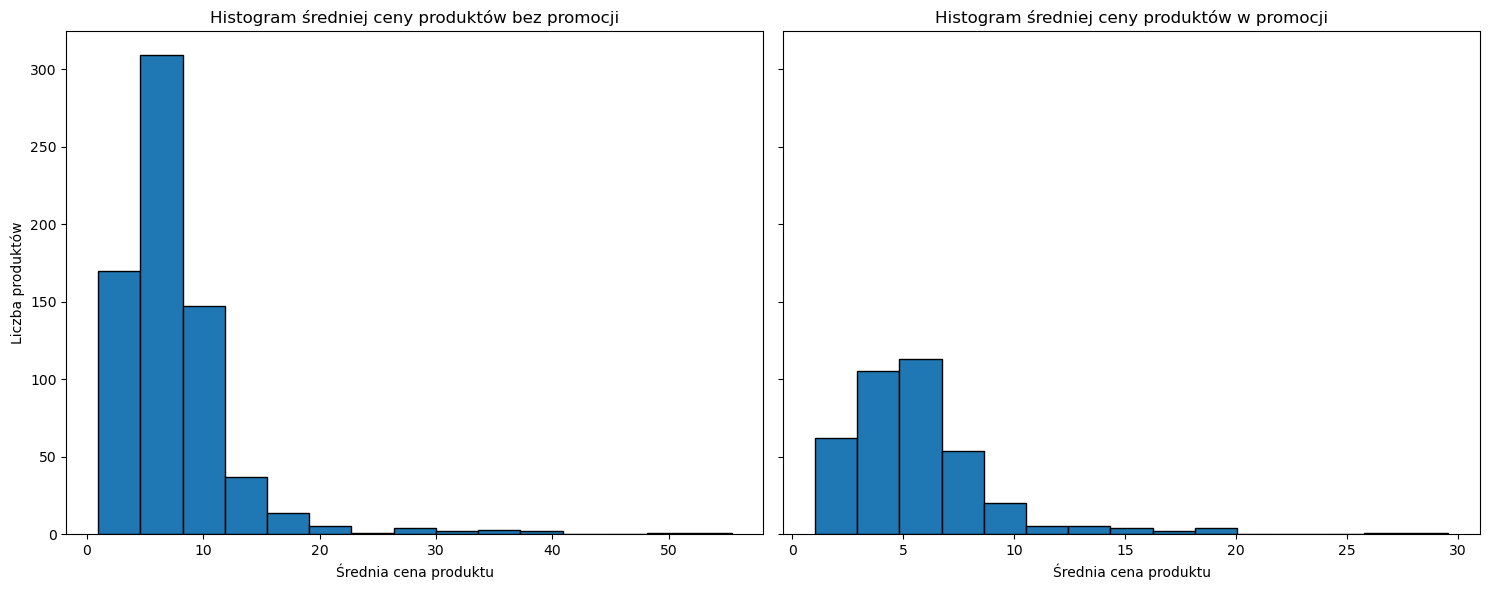

In [ ]:
# Dodaj kolumnę 'Promocja', która zawiera informacje, czy produkt był w promocji
df['Promocja'] = df['PROMO_KOD'].apply(lambda x: 'W promocji' if x != 0 else 'Bez promocji')

# Obliczanie średniej ceny dla każdego produktu (ART_ID) z podziałem na promocje
avg_price_per_product_promo = df.groupby(['ART_ID', 'Promocja'])['CENA_AP'].mean().reset_index()

# Tworzenie dwóch histogramów obok siebie
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Histogram dla cen bez promocji
axes[0].hist(avg_price_per_product_promo[avg_price_per_product_promo['Promocja'] == 'Bez promocji']['CENA_AP'], bins=15, edgecolor='black')
axes[0].set_title('Histogram średniej ceny produktów bez promocji')
axes[0].set_xlabel('Średnia cena produktu')
axes[0].set_ylabel('Liczba produktów')

# Histogram dla cen w promocji
axes[1].hist(avg_price_per_product_promo[avg_price_per_product_promo['Promocja'] == 'W promocji']['CENA_AP'], bins=15, edgecolor='black')
axes[1].set_title('Histogram średniej ceny produktów w promocji')
axes[1].set_xlabel('Średnia cena produktu')

plt.tight_layout()
plt.show()


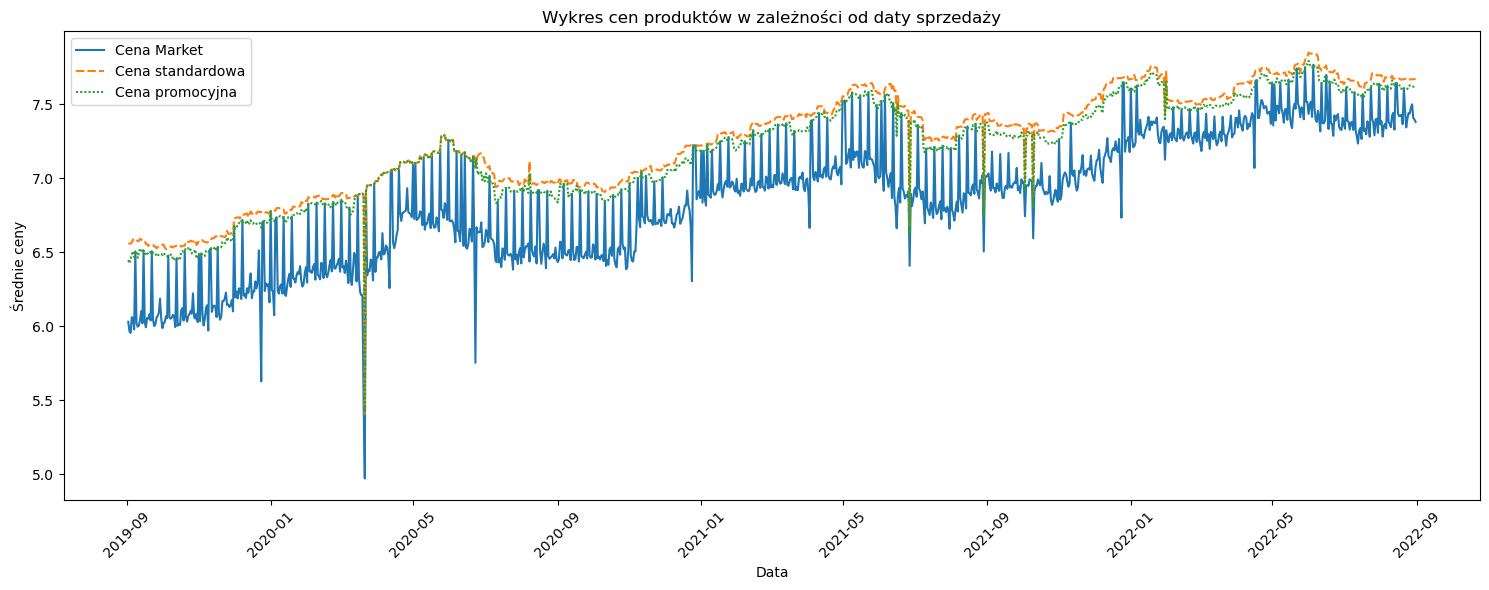

In [ ]:
plt.figure(figsize=(15, 4))
sns.lineplot(data=df.groupby('DATA').agg({'CENA_MARKET': 'mean', 'CENA_NP': 'mean', 'CENA_AP': 'mean'}))
plt.title('Wykres cen produktów w zależności od daty sprzedaży')
plt.xlabel('Data')
plt.ylabel('Średnie ceny')
plt.legend(['Cena Market', 'Cena standardowa', 'Cena promocyjna'], loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Obserwacja**: Uzupełnić

### Inne

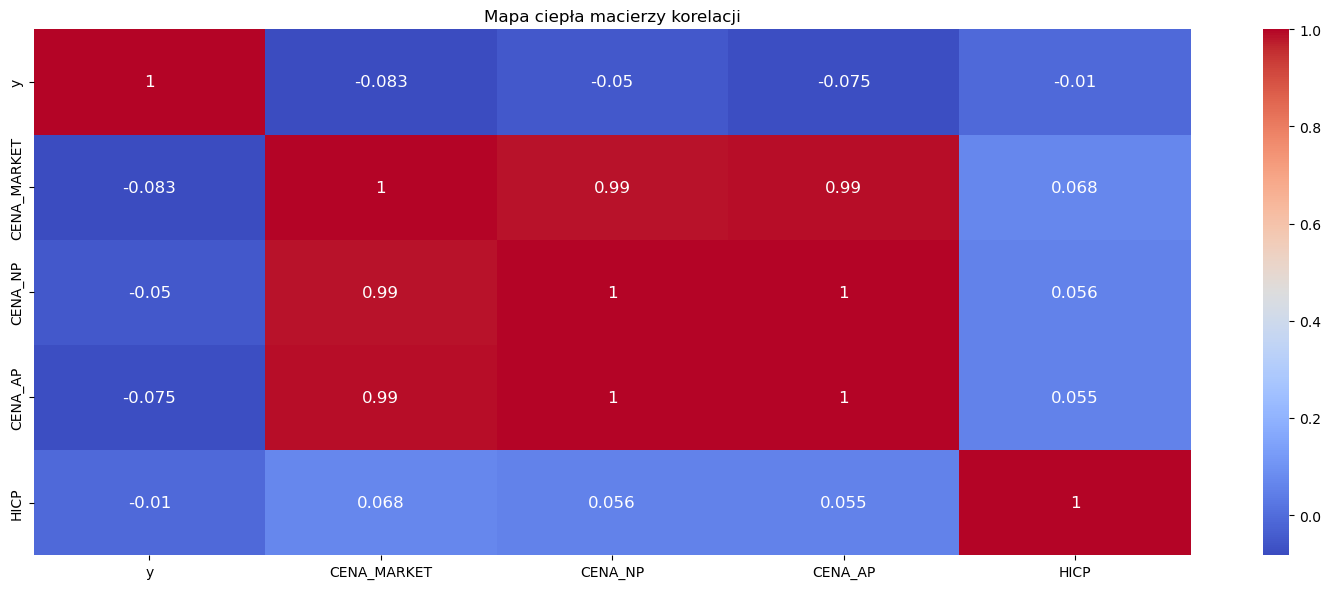

In [ ]:
# Macierz korelacji między kolumnami numerycznymi
num_columns = ['y', 'CENA_MARKET', 'CENA_NP', 'CENA_AP', 'HICP']
correlation_matrix = df[num_columns].corr()
# Mapa ciepła macierzy korelacji
plt.figure(figsize=(15, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 12})
plt.title('Mapa ciepła macierzy korelacji')
plt.tight_layout()
plt.show()

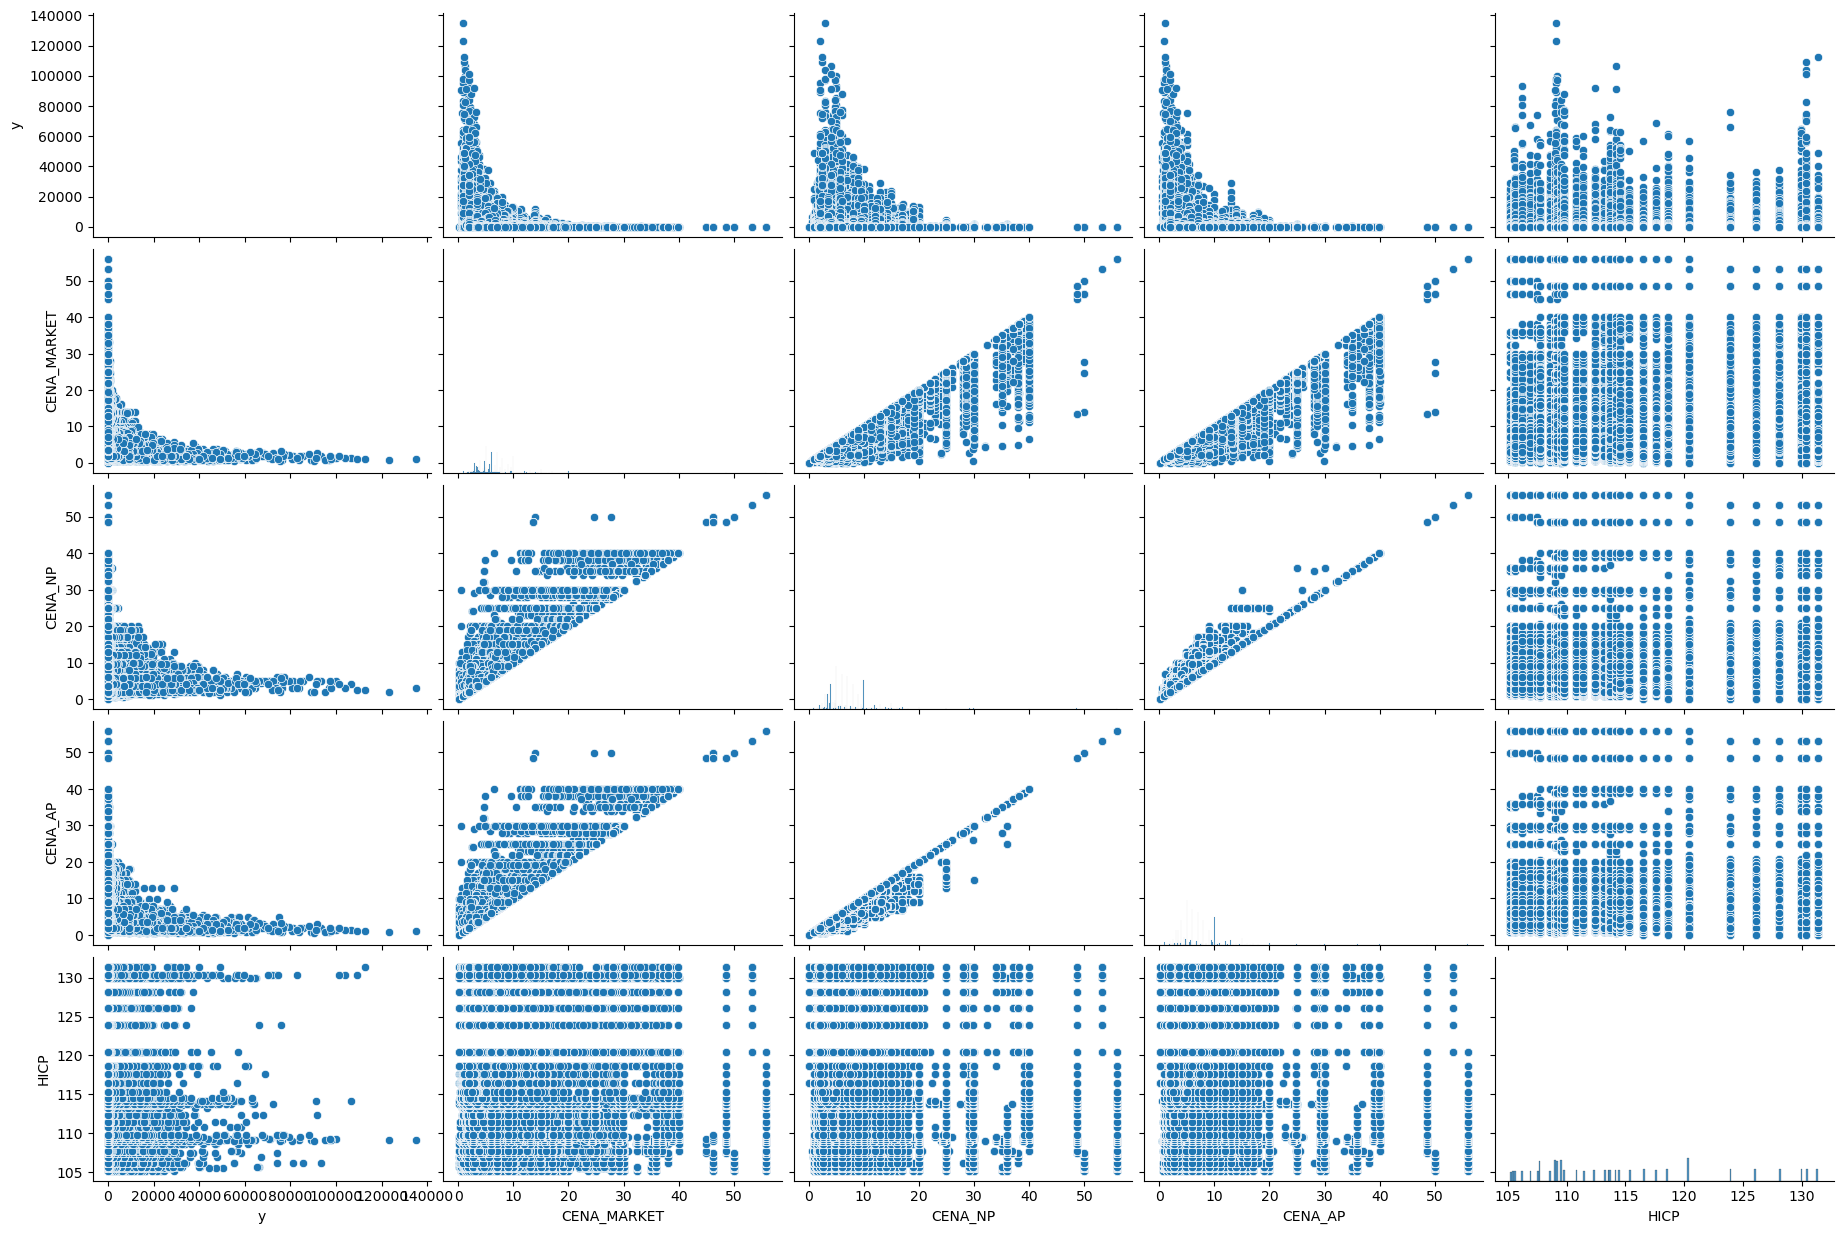

<Figure size 1500x1000 with 0 Axes>

In [ ]:
# Wykresy punktowe dla par zmiennych o wysokim współczynniku korelacji
sns.pairplot(df[['y', 'CENA_MARKET', 'CENA_NP', 'CENA_AP', 'HICP']], aspect = 15/10)
plt.figure(figsize=(15, 8))
plt.tight_layout()

In [ ]:
plt.show()

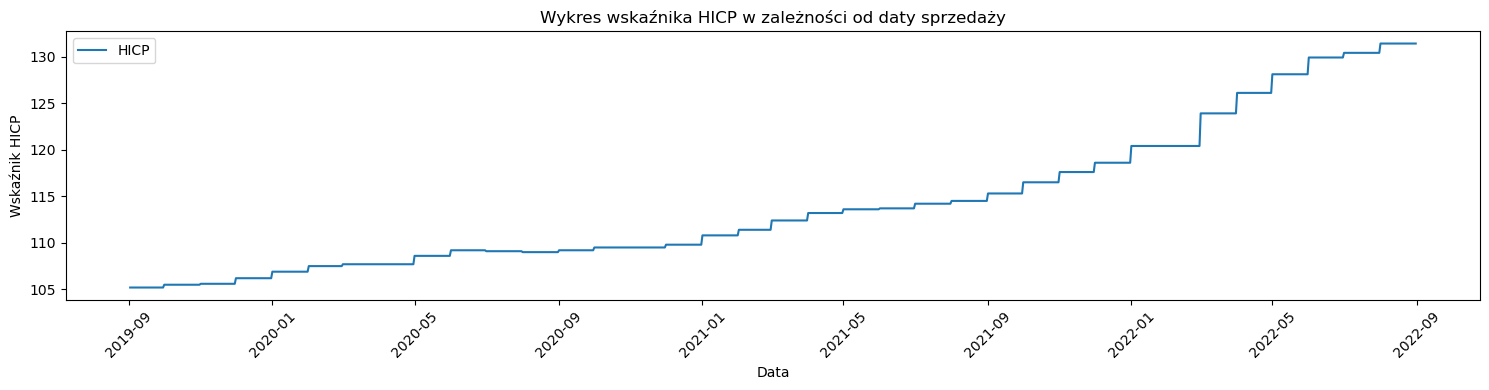

In [ ]:
plt.figure(figsize=(15, 4))
sns.lineplot(data=df.groupby('DATA').agg({'HICP': 'mean'}))
plt.title('Wykres wskaźnika HICP w zależności od daty sprzedaży')
plt.xlabel('Data')
plt.ylabel('Wskaźnik HICP')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Modelowanie

## Wybór technik modelowania

W niniejszym rozdziale omówione zostaną wybrane techniki modelowania, które zostaną zastosowane do predykcji szeregów czasowych w ramach metodologii CRISP-DM. Naszym celem jest wybór najlepszego modelu do przewidywania wartości na podstawie wcześniejszych danych. Zastosujemy kilka różnych podejść, aby zbadać efektywność poszczególnych metod.

Model podstawowy: **k Neighbors Regressor**
Jako punkt odniesienia wykorzystamy model k najbliższych sąsiadów (k Neighbors Regressor), który jest prostym, ale skutecznym algorytmem do rozwiązywania problemów regresji. Bazuje on na koncepcji wyboru k najbliższych obserwacji z przeszłości i obliczaniu średniej wartości dla prognozy.

**Dodatkowe testowane modele:**

**SARIMAX**  
SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) to rozbudowany model ARIMA, który uwzględnia zarówno sezonowość, jak i zmienne egzogeniczne. Jest on szczególnie przydatny do modelowania szeregów czasowych z sezonowymi wzorcami.

**Bayesian Time Series**  
Modele bayesowskie szeregów czasowych opierają się na podejściu statystycznym, które pozwala na łączenie wiedzy a priori z danymi obserwacyjnymi. Są one elastyczne i dobrze radzą sobie z niepewnością oraz zmiennością danych.

**XGBoost (Lasy Losowe)**  
XGBoost (eXtreme Gradient Boosting) to algorytm oparty na drzewach decyzyjnych, który optymalizuje gradient, podczas gdy lasy losowe polegają na łączeniu wielu drzew decyzyjnych, aby uzyskać lepsze prognozy.

**Sieci Neuronowe**  
W ramach sieci neuronowych zastosujemy różne architektury:

**1) Podstawowy model "Vanilla"**  |
Prosty model oparty na sieciach neuronowych, który skupia się na podstawowych warstwach sieci i aktywacji.

**2) Rozbudowany model DENSE**  
Zastosowanie większej liczby warstw gęstych (DENSE) pozwala na uczenie się bardziej złożonych reprezentacji danych.

**3) Rekurencyjne sieci LSTM i GRU**  
Long Short-Term Memory (LSTM) oraz Gated Recurrent Units (GRU) to specjalne rodzaje rekurencyjnych sieci neuronowych, które są doskonale przystosowane do modelowania danych szeregów czasowych, dzięki swojej zdolności do przetwarzania długotrwałych zależności czasowych.

**4) TFTModel**  
Temporal Fusion Transformer (TFTModel) to nowoczesna architektura oparta na transformerach. Składa się z wielu modułów, takich jak warstwy samo-uwagowe, warstwy rekurencyjne oraz warstwy gęste. TFTModel skutecznie łączy informacje o zależnościach czasowych oraz wzajemnych zależnościach między cechami, co pozwala na lepsze przewidywanie przyszłych wartości szeregów czasowych.

W procesie wyboru odpowiedniego modelu, każdy z powyższych modeli zostanie przetestowany, a ich wyniki zostaną porównane. Wybór odpowiedniej techniki modelowania pozwoli na uzyskanie najdokładniejszych prognoz na podstawie analizowanych danych. W kolejnych rozdziałach przedstawiony zostanie proces przygotowania danych, treningu modeli oraz ewaluacji ich wydajności, aby określić najlepsze podejście do rozwiązania problemu predykcji szeregów czasowych w ramach metodologii CRISP-DM.

## Budowa modeli oraz testów dla jednowymiarowych szeregów czasowych

#### Import i preprocesing danych

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Wczytanie danych
df = pd.read_pickle('/content/drive/MyDrive/DS Projekt/PICKLE/df_3.pkl')
#df = pd.read_pickle('PICKLE/df_3.pkl')

In [ ]:
# Ograniczenie danych do jednego klastra oraz wybranie jednego arrtykułu
df = df.loc[df['CLUSTER']==2].drop(['CLUSTER'], axis=1)
df = df.loc[df['ART_ID']==158].drop(['ART_ID', 'GRUPA_ID', 'NAZWA'], axis=1) 

In [ ]:
df.shape

(1095, 17)

In [ ]:
df.set_index('DATA', inplace=True)

In [ ]:
# Podział danych na sprzedaż promocyjną i niepromocyjną
df_promo = df.loc[df['PROMO_KOD']!=0]
df_nonpromo = df.loc[df['PROMO_KOD']==0]

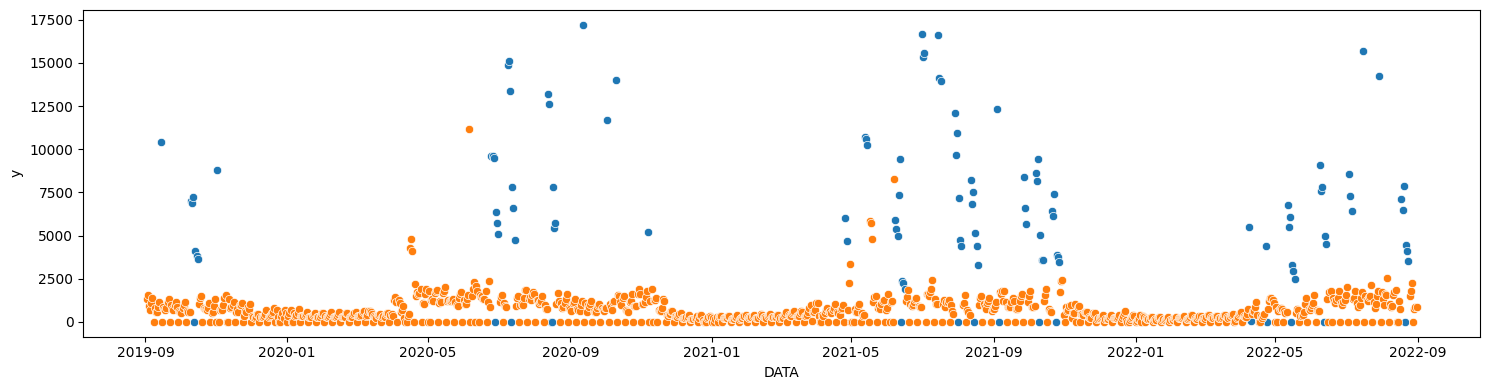

In [ ]:
# Scatter plot sprzedaży
plt.figure(figsize=(15, 4))
sns.scatterplot(data=df_promo, x=df_promo.index, y='y')
sns.scatterplot(data=df_nonpromo, x=df_nonpromo.index, y='y')
plt.tight_layout()
plt.show()

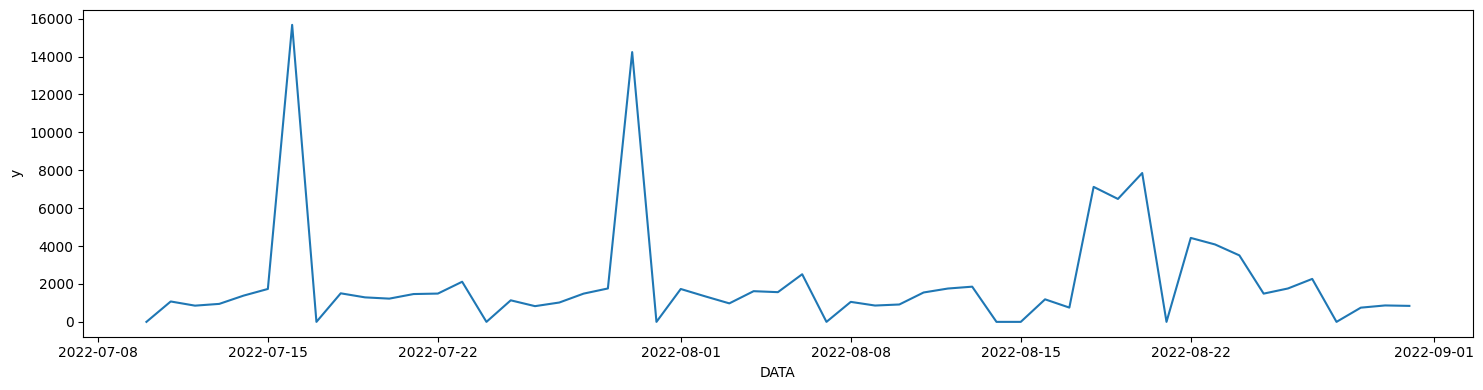

In [ ]:
# Lineplot sprzedaży za okres 'testowy'
plt.figure(figsize=(15, 4))
sns.lineplot(data=df.loc[df.index>='2022-07-10'], x=df.index[df.index>='2022-07-10'], y='y')
plt.tight_layout()
plt.show()

**Obeserwacja**: Wybrany okres zawiera 3 promocje: dwie jednodniowe i jedną promocję tygodniową.

##### Kodowanie danych

In [ ]:
# Definicja kolumn względem typu danych
nominal_columns = ['PROMO_KOD', 'Dn_handlowy', 'Hot_day']
ordinal_columns = ['Hot_day_Xmass', 'Hot_day_Wlkn', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 'Nr_rok']
numeric_columns = ['CENA_MARKET', 'CENA_AP', 'CENA_NP', 'PRZECENA', 'HICP']

# Tworzenie przekształceń
nominal_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
numeric_transformer = MinMaxScaler()

# Tworzenie ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_columns),
        ('ordinal', ordinal_transformer, ordinal_columns),
        ('numeric', numeric_transformer, numeric_columns)
    ])

# Tworzenie pipeline'u
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Przekształcanie danych
X_train, y_train = df.loc[df.index <='2022-07-10 00:00:00'], df.loc[df.index <= '2022-07-10 00:00:00']
X_test, y_test = df.loc[df.index>'2022-07-10 00:00:00'], df.loc[df.index > '2022-07-10 00:00:00']
X_train = X_train.drop(columns=['y'])
X_test = X_test.drop(columns=['y'])
y_train = y_train['y']
y_test = y_test['y']

# Zastosowanie pipeline'ow
X_trans_transformed = pipeline.fit_transform(X_train)
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [ ]:
# Przekształć kolumny nominalne za pomocą OneHotEncoder i pobierz ich nazwy
nominal_transformed_columns = nominal_transformer.fit(X_train[nominal_columns]).get_feature_names_out(nominal_columns)

# Połącz nazwy kolumn nominalnych, porządkowych i numerycznych
transformed_columns = np.concatenate((nominal_transformed_columns, ordinal_columns, numeric_columns))

# Utwórz przekształcone DataFrame z przekształconymi nazwami kolumn
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_columns)
X_trans_transformed = pd.DataFrame(X_trans_transformed, columns=transformed_columns)


In [ ]:
print(X_train_transformed.shape)
print(y_train.shape)
print(X_test_transformed.shape)
print(y_test.shape)

(1043, 26)
(1043,)
(52, 26)
(52,)


In [ ]:
X_train_transformed_df.head(2)

PROMO_KOD_0  PROMO_KOD_3  PROMO_KOD_4  PROMO_KOD_5  PROMO_KOD_8  \
0          1.0          0.0          0.0          0.0          0.0   
1          1.0          0.0          0.0          0.0          0.0   

   PROMO_KOD_20  PROMO_KOD_58  PROMO_KOD_107  PROMO_KOD_115  PROMO_KOD_118  \
0           0.0           0.0            0.0            0.0            0.0   
1           0.0           0.0            0.0            0.0            0.0   

   Dn_handlowy_0  Dn_handlowy_1  Hot_day_0  Hot_day_1  Hot_day_Xmass  \
0            0.0            1.0        1.0        0.0           14.0   
1            0.0            1.0        1.0        0.0           14.0   

   Hot_day_Wlkn  Nr_dn_tyg  Nr_dn_mies  Nr_mies  Nr_tyg  Nr_rok  CENA_MARKET  \
0          14.0        0.0         1.0      8.0    35.0     0.0     0.150303   
1          14.0        1.0         2.0      8.0    35.0     0.0     0.095115   

    CENA_AP   CENA_NP  PRZECENA  HICP  
0  0.161677  0.034483       0.0   0.0  
1  0.161677  0.034483       0.0   0.0

### Model bazowy - KNN

In [ ]:
# Parametry
n_neighbors_values = np.arange(1, 25, 1)
weights_values = ["uniform", "distance"]
algorithm_values = ["auto", "ball_tree", "kd_tree", "brute"]
leaf_size_values = np.arange(1, 5, 1)
p_values = [1, 2]

# Tworzenie kombinacji parametrów
param_combinations_KNR = list(product(n_neighbors_values, weights_values, algorithm_values, leaf_size_values, p_values))
len(param_combinations_KNR)

1536

In [ ]:
# Inicjalizacja ramki danych do przechowywania wyników metryk dla każdego foldu
results_df_KNR = pd.DataFrame(columns=["Fold", "n_neighbors", "weights", "algorithm", "leaf_size", "p", "MAE", "RMSE", "R2", "MAPE", "MASE"])

# Tworzenie obiektu TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5) 

In [ ]:
# Inicjalizacja ramki danych do przechowywania najlepszych wyników metryk dla każdego foldu
best_results_df_KNR = pd.DataFrame(columns=["Fold", "n_neighbors", "weights", "algorithm", "leaf_size", "p", "MAE", "RMSE", "R2", "MAPE", "MASE"])

# Iteracja po foldach
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train_KNR = X_train_transformed_df.iloc[train_index]
    X_test_KNR = X_train_transformed_df.iloc[test_index]
    y_train_KNR = y_train.iloc[train_index]
    y_test_KNR = y_train.iloc[test_index]

    best_rmse = float('inf')
    best_params = None
    best_mae, best_rmse, best_r2, best_mape, best_mase = float('inf'), float('inf'), float('-inf'), float('inf'), float('inf')


    for params in param_combinations_KNR:
        n_neighbors, weights, algorithm, leaf_size, p = params
        KNR = KNeighborsRegressor(
            n_neighbors=n_neighbors,
            weights=weights,
            algorithm=algorithm,
            leaf_size=leaf_size,
            p=p
        )
        KNR.fit(X_train_KNR, y_train_KNR)
        y_pred_KNR = KNR.predict(X_test_KNR)
        rmse = mean_squared_error(y_test_KNR, y_pred_KNR, squared=False)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_mae, best_rmse, best_r2, best_mape, best_mase = ff.metryki(y_test_KNR, y_pred_KNR)

    # Utworzenie najlepszego modelu
    n_neighbors, weights, algorithm, leaf_size, p = best_params
    KNR = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p
    )
    KNR.fit(X_train_KNR, y_train_KNR)
    y_pred = KNR.predict(X_test_KNR)

    # Zapisanie najlepszych wyników metryk dla foldu
    best_results_df_KNR = best_results_df_KNR.append({"Fold": fold, "n_neighbors": n_neighbors, "weights": weights,
                                    "algorithm": algorithm, "leaf_size": leaf_size, "p": p,
                                    "MAE": best_mae, "RMSE": best_rmse, "R2": best_r2, "MAPE": best_mape, "MASE": best_mase}, ignore_index=True)

# Skopiowanie najlepszych wyników metryk do wynikowej ramki danych
results_df_KNR = best_results_df_KNR.copy()

In [ ]:
# Wyświetlenie ramki danych z wynikami metryk dla każdego foldu
results_df_KNR.head()

In [ ]:
# Tworzenie predykcji
y_predict_KNR = KNR.predict(X_test_transformed_df)
y_predict_KNR_past = KNR.predict(X_train_transformed_df)

In [ ]:
# Tworzenie DataFrame do wizualizacji
KNR_pred = df.loc[df.index >'2022-07-10 00:00:00'][['y']]
KNR_pred['y_test'] = KNR_pred['y']
KNR_pred = KNR_pred.drop('y', axis=1)
KNR_pred['y_predict'] = y_predict_KNR

In [ ]:
KNR_pred

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=KNN_pred, x=KNN_pred.index, y='y_test')
sns.lineplot(data=KNN_pred, x=KNN_pred.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_KNR, rmse_KNR, r2_KNR, mape_KNR, mase_KNR = ff.metryki(y_test, y_predict_KNN)
print(f"MAE: {mae_KNR:.4f}, RMSE: {rmse_KNR:.4f}, R2: {r2_KNR:.4f}, MAPE: {mape_KNR:.4f}%, MASE: {mase_KNR:.4f}")

### SARIMAX

#### Badanie stacjonarności danych

Przed użyciem modelu (S)ARIMA(X) konieczne jest zbadanie stacjonarności danych. Aby wykonać ten krok wykorzystamy dwa testy: *Test Dickeya-Fullera powiększonego (ADF)* oraz *KPSS* dla których stawiamy najstępujące hipotezy:

**Test Dickeya-Fullera powiększonego (ADF):**

*Hipoteza zerowa (H0):*  
Dane mają jednostkowy korzenˊ, czyli są niestacjonarne

*Hipoteza alternatywna (H1):*  
Dane nie mają jednostkowego korzenia, czyli są stacjonarne

**Test KPSS:**

*Hipoteza zerowa (H0):*  
Dane są stacjonarne w sensie stacjonarności słabej (stacjonarność w ścisłym tego słowa znaczeniu lub stacjonarność z trendem)

*Hipoteza alternatywna (H1):*   
Dane są niestacjonarne


In [ ]:
# Test Dickeya-Fullera powiększonego (ADF)
result_adf = adfuller(y_train)
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')

ADF Statistic: -3.441555343129404
p-value: 0.009621238013165662


**Obserwacja**: W przypadku testu ADF, wartość p wynosi 0.0096, co jest mniejsze niż poziom istotności 0,05. Oznacza to, że odrzucamy hipotezę zerową o braku stacjonarności i przyjmujemy, że dane są stacjonarne.

In [ ]:
# Test KPSS
result_kpss = kpss(y_train)
print(f'KPSS Statistic: {result_kpss[0]}')
print(f'p-value: {result_kpss[1]}')

KPSS Statistic: 0.23627898343295728
p-value: 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


**Obserwacja:** W przypadku testu KPSS, wartość p wynosi 0.236, co jest większe niż poziom istotności 0,05. Oznacza to, że nie ma podstaw do odrzucenia hipotezy zerowej, która mówi, że dane są stacjonarne.

Podsumowując, wyniki obu testów sugerują, że dane są stacjonarne. Warto jednak zauważyć, że test KPSS generuje ostrzeżenie o tym, że wartość statystyki testowej znajduje się poza zakresem wartości p dostępnych w tabeli. W takim przypadku wartość p może być niedokładna. Mimo to, wyniki obu testów wskazują na stacjonarność danych.

#### Budowa modelu

In [ ]:
from pmdarima import auto_arima
import pandas as pd

# Inicjalizacja ramki danych do przechowywania wyników metryk dla każdego foldu
results_df_SARIMAX = pd.DataFrame(columns=["Fold", "order", "seasonal_order", "AIC", "BIC", "MAE", "RMSE", "R2", "MAPE", "MASE"])

# Tworzenie obiektu TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Iteracja po foldach
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train_SARIMAX = X_train.iloc[train_index]
    X_test_SARIMAX = X_train.iloc[test_index]
    y_train_SARIMAX = y_train.iloc[train_index]
    y_test_SARIMAX = y_train.iloc[test_index]

    # AutoARIMA - automatyczne dopasowanie modelu SARIMAX
    SARIMAX = auto_arima(X=X_train_SARIMAX, y=y_train_SARIMAX, error_action="ignore")

    # Przewidywanie wartości
    y_pred = SARIMAX.predict(n_periods=len(X_test_SARIMAX), X=X_test_SARIMAX)

    # Obliczanie metryk
    mae, rmse, r2, mape, mase = ff.metryki(y_test_SARIMAX, y_pred)

    # Zapisanie wyników metryk dla foldu
    results_df_SARIMAX = results_df_SARIMAX.append({"Fold": fold, "order": model.order, "seasonal_order": model.seasonal_order,
                                                    "AIC": model.aic(), "BIC": model.bic(),
                                                    "MAE": mae, "RMSE": rmse, "R2": r2, "MAPE": mape, "MASE": mase},
                                                   ignore_index=True)

# Wyświetlenie ramki danych z wynikami metryk dla każdego foldu
results_df_SARIMAX.head()


Fold      order seasonal_order          AIC           BIC           MAE  \
0    0  (1, 0, 0)   (0, 0, 0, 0)  14814.04245  14895.106835  10182.373648   
1    1  (1, 0, 0)   (0, 0, 0, 0)  14814.04245  14895.106835    809.427482   
2    2  (1, 0, 0)   (0, 0, 0, 0)  14814.04245  14895.106835   4517.155896   
3    3  (1, 0, 0)   (0, 0, 0, 0)  14814.04245  14895.106835    827.550039   
4    4  (1, 0, 0)   (0, 0, 0, 0)  14814.04245  14895.106835    624.099716   

           RMSE          R2  MAPE      MASE  
0  33876.207769 -145.673841   inf  8.209899  
1   1080.319862    0.700385   inf  0.939896  
2  16467.747114  -23.299269   inf  3.826659  
3   1579.267057    0.563914   inf  0.764962  
4    978.420577    0.674121   inf  0.866644

In [ ]:
# Tworzenie predykcji
y_predict_SARIMAX = SARIMAX.predict(n_periods=len(y_test), X=X_test)

In [ ]:
# Tworzenie DataFrame do wizualizacji
SARIMAX_pred = df.loc[df.index >'2022-07-10 00:00:00'][['y']]
SARIMAX_pred['y_test'] = SARIMAX_pred['y']
SARIMAX_pred = SARIMAX_pred.drop('y', axis=1)
SARIMAX_pred = SARIMAX_pred.reset_index()
SARIMAX_pred['y_predict'] = y_predict_SARIMAX.reset_index(drop=True)

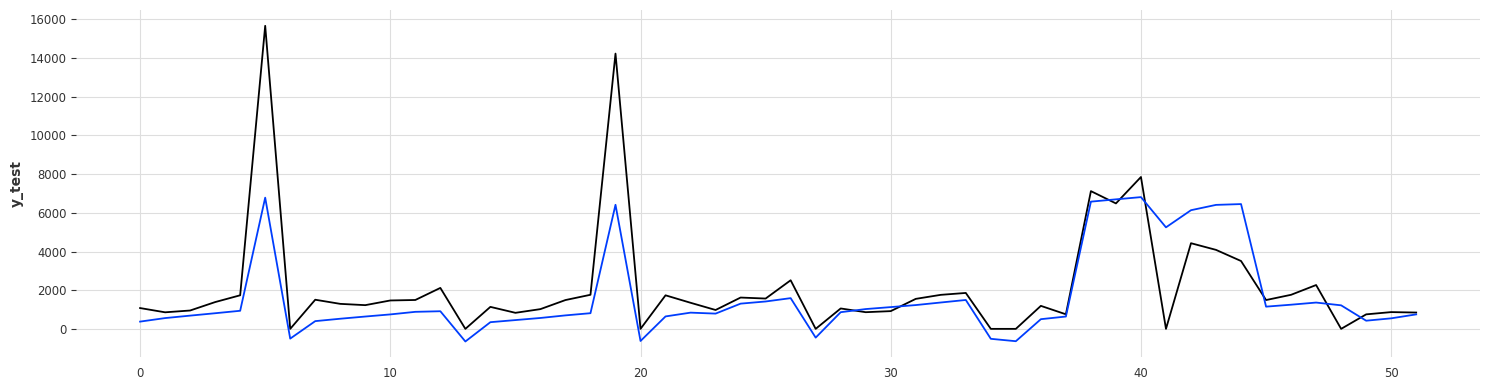

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=SARIMAX_pred, x=SARIMAX_pred.index, y='y_test')
sns.lineplot(data=SARIMAX_pred, x=SARIMAX_pred.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_SARIMAX, rmse_SARIMAX, r2_SARIMAX, mape_SARIMAX, mase_SARIMAX = ff.metryki(y_test, y_predict_SARIMAX.reset_index(drop=True))
print(f"MAE: {mae_SARIMAX:.4f}, RMSE: {rmse_SARIMAX:.4f}, R2: {r2_SARIMAX:.4f}, MAPE: {mape_SARIMAX:.4f}%, MASE: {mase_SARIMAX:.4f}")

MAE: 1047.7152, RMSE: 1975.9936, R2: 0.5787, MAPE: nan%, MASE: 0.5114


/content/functions.py:75: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_predict) / y_true)) * 100


### Prophet - chyba OK

In [ ]:
# Dane treningowe i testowe
df_prophet = df.reset_index().rename(columns={'DATA': 'ds'})
train = df_prophet[df_prophet.ds < '2022-07-10']
test = df_prophet[df_prophet.ds >= '2022-07-10']

# Tworzenie modelu
prophet_model = Prophet(growth = "linear",
                        yearly_seasonality = True,
                        weekly_seasonality = True,
                        daily_seasonality = False,
                        #holidays = holidays,
                        seasonality_mode = "multiplicative",
                        seasonality_prior_scale = 20,
                        holidays_prior_scale = 20,
                        changepoint_prior_scale = 0.01)
prophet_model.add_regressor('CENA_NP')  # Zmienne egzogeniczne
prophet_model.add_regressor('CENA_AP')
prophet_model.add_regressor('PRZECENA')
prophet_model.add_regressor('CENA_MARKET')
prophet_model.add_regressor('PROMO_KOD')
prophet_model.add_regressor('Nr_dn_tyg')
prophet_model.add_regressor('Nr_dn_mies')
prophet_model.add_regressor('Nr_mies')
prophet_model.add_regressor('Nr_tyg')
prophet_model.add_regressor('Nr_rok')
prophet_model.add_regressor('Dn_handlowy')
prophet_model.add_regressor('Hot_day')
prophet_model.add_regressor('Hot_day_Xmass')
prophet_model.add_regressor('Hot_day_Wlkn')
prophet_model.add_regressor('HICP')

prophet_model.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbyvpbfm3/d49a4_g8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbyvpbfm3/lgdgv3wn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94924', 'data', 'file=/tmp/tmpbyvpbfm3/d49a4_g8.json', 'init=/tmp/tmpbyvpbfm3/lgdgv3wn.json', 'output', 'file=/tmp/tmpbyvpbfm3/prophet_model_re05no3/prophet_model-20230530044012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:40:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:40:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Ramka danych do przedykcji
test_prophet = test.drop('y', axis=1)
test_prophet.reset_index(drop=True, inplace=True)

In [ ]:
# Predykcja
prophet_forecast = prophet_model.predict(test_prophet)

In [ ]:
prophet_forecast

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0  2022-07-10  1026.940757 -1026.108575  1841.266360  1026.940757   
1  2022-07-11  1026.567983  -217.740466  2678.267742  1026.567983   
2  2022-07-12  1026.195210  -324.994777  2557.850639  1026.195210   
3  2022-07-13  1025.822436  -404.708566  2730.191569  1025.822436   
4  2022-07-14  1025.449663   246.417781  3063.645750  1025.449663   
..        ...          ...          ...          ...          ...   
48 2022-08-27  1009.047629    -6.262945  2905.215993  1008.281922   
49 2022-08-28  1008.674856 -1489.844017  1328.292666  1007.881101   
50 2022-08-29  1008.302082  -698.686865  2138.096485  1007.485260   
51 2022-08-30  1007.929309  -878.898264  1956.362124  1007.073923   
52 2022-08-31  1007.556535  -816.262522  2021.259867  1006.670568   

    trend_upper   CENA_AP  CENA_AP_lower  CENA_AP_upper  CENA_MARKET  \
0   1026.940757 -0.005613      -0.005613      -0.005613     0.286774   
1   1026.567983 -0.005613      -0.005613      -0.005613     0.287079   
2   1026.195210 -0.005613      -0.005613      -0.005613     0.288200   
3   1025.822436 -0.005613      -0.005613      -0.005613     0.286774   
4   1025.449663 -0.005613      -0.005613      -0.005613     0.286774   
..          ...       ...            ...            ...          ...   
48  1009.967538 -0.008564      -0.008564      -0.008564     0.561098   
49  1009.620471 -0.008564      -0.008564      -0.008564     0.477463   
50  1009.270369 -0.008564      -0.008564      -0.008564     0.477473   
51  1008.927724 -0.008564      -0.008564      -0.008564     0.477463   
52  1008.606936 -0.008564      -0.008564      -0.008564     0.503255   

    CENA_MARKET_lower  CENA_MARKET_upper   CENA_NP  CENA_NP_lower  \
0            0.286774           0.286774 -0.072127      -0.072127   
1            0.287079           0.287079 -0.072127      -0.072127   
2            0.288200           0.288200 -0.072127      -0.072127   
3            0.286774           0.286774 -0.072127      -0.072127   
4            0.286774           0.286774 -0.072127      -0.072127   
..                ...                ...       ...            ...   
48           0.561098           0.561098 -0.105947      -0.105947   
49           0.477463           0.477463 -0.105947      -0.105947   
50           0.477473           0.477473 -0.105947      -0.105947   
51           0.477463           0.477463 -0.105947      -0.105947   
52           0.503255           0.503255 -0.105947      -0.105947   

    CENA_NP_upper  Dn_handlowy  Dn_handlowy_lower  Dn_handlowy_upper  \
0       -0.072127     0.000000           0.000000           0.000000   
1       -0.072127     0.106762           0.106762           0.106762   
2       -0.072127     0.106762           0.106762           0.106762   
3       -0.072127     0.106762           0.106762           0.106762   
4       -0.072127     0.106762           0.106762           0.106762   
..            ...          ...                ...                ...   
48      -0.105947     0.106762           0.106762           0.106762   
49      -0.105947     0.106762           0.106762           0.106762   
50      -0.105947     0.106762           0.106762           0.106762   
51      -0.105947     0.106762           0.106762           0.106762   
52      -0.105947     0.106762           0.106762           0.106762   

        HICP  HICP_lower  HICP_upper  Hot_day  Hot_day_lower  Hot_day_upper  \
0   0.092132    0.092132    0.092132      0.0            0.0            0.0   
1   0.092132    0.092132    0.092132      0.0            0.0            0.0   
2   0.092132    0.092132    0.092132      0.0            0.0            0.0   
3   0.092132    0.092132    0.092132      0.0            0.0            0.0   
4   0.092132    0.092132    0.092132      0.0            0.0            0.0   
..       ...         ...         ...      ...            ...            ...   
48  0.097516    0.097516    0.097516      0.0            0.0          

In [ ]:
# Tworzenie DataFrame do wizualizacji
y_true = test['y'].reset_index(drop=True)
y_pred = prophet_forecast['yhat'].reset_index(drop=True)
result_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})

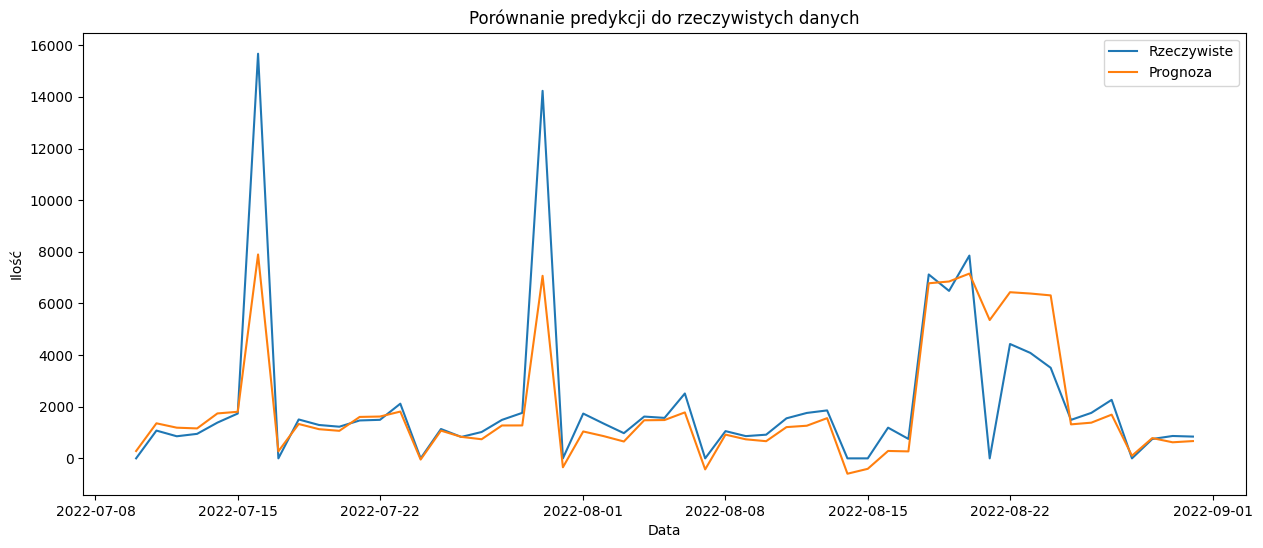

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
plt.plot(test.ds, result_df['y_true'], label='Rzeczywiste')
plt.plot(test.ds, result_df['y_pred'], label='Prognoza')
plt.xlabel('Data')
plt.ylabel('Ilość')
plt.title('Porównanie predykcji do rzeczywistych danych')
plt.legend()
plt.show()

In [ ]:
# Metryki
mae_prophet, rmse_prophet, r2_prophet, mape_prophet, mase_prophet = ff.metryki(y_true, y_pred)
print(f"MAE: {mae_prophet:.4f}, RMSE: {rmse_prophet:.4f}, R2: {r2_prophet:.4f}, MAPE: {mape_prophet:.4f}%, MASE: {mase_prophet:.4f}")

MAE: 787.1773, RMSE: 1758.4031, R2: 0.6631, MAPE: inf%, MASE: 0.3878


In [ ]:
type(y_pred)

pandas.core.series.Series

### XGBoost - OK

#### Przygotowanie danych

In [ ]:
# Wczytanie danych
df = pd.read_pickle('/content/drive/MyDrive/DS Projekt/PICKLE/df_3.pkl')
# Ograniczenie danych do jednego klastra oraz wybranie jednego arrtykułu
df = df.loc[df['CLUSTER']==2].drop(['CLUSTER'], axis=1)
df = df.loc[df['ART_ID']==158].drop(['ART_ID', 'GRUPA_ID', 'NAZWA'], axis=1) 
df.set_index('DATA', inplace=True)
#Kopia
df_XGB = df.copy()

In [ ]:
# Definicja kolumn względem typu danych
nominal_columns = ['PROMO_KOD', 'Dn_handlowy', 'Hot_day']
ordinal_columns = ['Hot_day_Xmass', 'Hot_day_Wlkn', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 'Nr_rok']
numeric_columns = ['CENA_MARKET', 'CENA_AP', 'CENA_NP', 'PRZECENA', 'HICP']

# Tworzenie przekształceń
nominal_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
numeric_transformer = MinMaxScaler()

# Tworzenie ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_columns),
        ('ordinal', ordinal_transformer, ordinal_columns),
        ('numeric', numeric_transformer, numeric_columns)
    ])

# Tworzenie pipeline'u
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Przekształcanie danych
X_train, y_train = df_XGB.loc[df_XGB.index <='2022-07-10 00:00:00'], df_XGB.loc[df_XGB.index <= '2022-07-10 00:00:00']
X_test, y_test = df_XGB.loc[df_XGB.index>'2022-07-10 00:00:00'], df_XGB.loc[df_XGB.index > '2022-07-10 00:00:00']
X_train = X_train.drop(columns=['y'])
X_test = X_test.drop(columns=['y'])
y_train = y_train['y']
y_test = y_test['y']

#### Gradient Boosting - OK

In [ ]:
# Parametry
n_estimators_values = [500, 1500] #[50, 100, 300, 500]
learning_rate_values = [0.01, 0.02] #[0.01, 0.02, 0.05, 0.1, 0.2]
max_depth_values = [3, 5] #[3, 6, 8, 10, 12]

In [ ]:
# Tworzenie kombinacji parametrów
param_combinations_XGB = list(product(n_estimators_values, learning_rate_values, max_depth_values))
len(param_combinations_XGB)

8

In [ ]:
# Inicjalizacja ramki danych do przechowywania wyników metryk dla każdego foldu
results_df_XGB = pd.DataFrame(columns=["Fold", "n_estimators", "learning_rate", "max_depth", "MAE", "RMSE", "R2", "MAPE", "MASE"])

# Tworzenie obiektu TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# Iteracja po foldach
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train_XGB = X_train.iloc[train_index]
    X_test_XGB = X_train.iloc[test_index]
    y_train_XGB = y_train.iloc[train_index]
    y_test_XGB = y_train.iloc[test_index]
    # Kodowanie
    X_train_XGB = pipeline.fit_transform(X_train_XGB)
    X_test_XGB = pipeline.transform(X_test_XGB)
   
    best_rmse = float('inf')
    best_params = None

    # Iteracja po kombinacjach parametrów
    for params in param_combinations_XGB:
        n_estimators, learning_rate, max_depth = params
        XGB = xgb.XGBRegressor(objective='reg:squarederror',
                                n_jobs=-1, 
                                random_state=42,
                                n_estimators=n_estimators,
                                learning_rate=learning_rate,
                                max_depth=max_depth)#,
                                #tree_method='gpu_hist'
                                #)
        XGB.fit(X_train_XGB, y_train_XGB)
        y_pred_XGB = XGB.predict(X_test_XGB)
        rmse = mean_squared_error(y_test_XGB, y_pred_XGB, squared=False)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    # Utworzenie najlepszego modelu
    n_estimators, learning_rate, max_depth = best_params
    XGB = xgb.XGBRegressor(objective='reg:squarederror',
                            n_jobs=-1, 
                            random_state=42,
                            n_estimators=n_estimators,
                            learning_rate=learning_rate,
                            max_depth=max_depth)#,
                                #tree_method='gpu_hist'
                                #)
    XGB.fit(X_train_XGB, y_train_XGB)
    y_pred_XGB = XGB.predict(X_test_XGB)

    # Obliczenie metryk
    best_mae, best_rmse, best_r2, best_mape, best_mase = ff.metryki(y_test_XGB, y_pred_XGB)

    # Dodanie najlepszych wyników metryk do ramki danych
    results_df_XGB = results_df_XGB.append({"Fold": fold, "n_estimators": n_estimators,
                                                        "learning_rate": learning_rate, "max_depth": max_depth,
                                                        "MAE": best_mae, "RMSE": best_rmse, "R2": best_r2,
                                                        "MAPE": best_mape, "MASE": best_mase}, ignore_index=True)

In [ ]:
# Wyświetlenie ramki danych z wynikami metryk dla każdego foldu
results_df_XGB.head()

Fold  n_estimators  learning_rate  max_depth         MAE         RMSE  \
0   0.0        1500.0           0.02        3.0  932.726440  1841.917847   
1   1.0         500.0           0.02        3.0  404.422729   648.143066   
2   2.0        1500.0           0.02        5.0  636.859192  1515.611084   
3   3.0        1500.0           0.01        3.0  367.920868   659.642700   
4   4.0         500.0           0.02        3.0  360.288879   704.063232   

         R2          MAPE      MASE  
0  0.566386  1.663564e+14  0.752044  
1  0.892155  3.777074e+13  0.469610  
2  0.794174  2.187412e+13  0.539508  
3  0.923919  3.889206e+13  0.340095  
4  0.831256  3.411760e+13  0.500308

In [ ]:
# Najlepsze parametry XGBRegressor
print("Najlepsze parametry znalezione:", XGB.get_params())

Najlepsze parametry znalezione: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.02, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 500, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


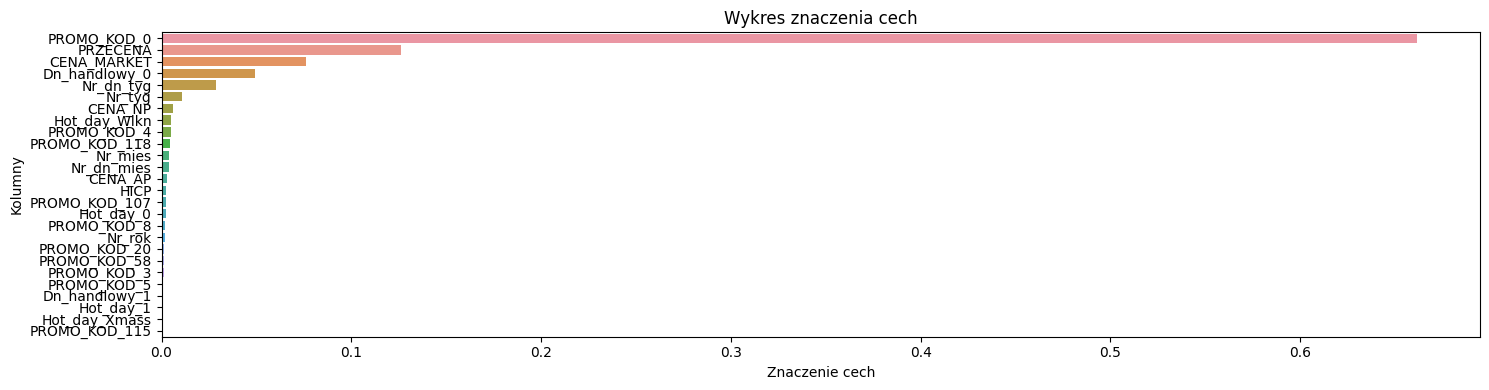

In [ ]:
# Pobieranie znaczenia cech z modelu
importance_scores = XGB.feature_importances_

# Tworzenie słownika mapującego indeksy kolumn na nazwy oryginalne
column_names = []
column_transformers = preprocessor.transformers_
for transformer_name, transformer, column_indices in column_transformers:
    if transformer_name == 'nominal':
        nominal_column_names = transformer.get_feature_names_out(nominal_columns)
        column_names.extend(nominal_column_names)
    elif transformer_name == 'ordinal':
        ordinal_column_names = column_indices
        column_names.extend(ordinal_column_names)
    elif transformer_name == 'numeric':
        numeric_column_names = numeric_columns
        column_names.extend(numeric_column_names)

# Sortowanie cech według znaczenia
sorted_indices = importance_scores.argsort()[::-1]
sorted_column_names = [column_names[i] for i in sorted_indices]
sorted_importance_scores = importance_scores[sorted_indices]

# Generowanie wykresu znaczenia cech z dostosowanymi etykietami przy użyciu Seaborn
plt.figure(figsize=(15, 4))
sns.barplot(x=sorted_importance_scores, y=sorted_column_names, orient='h')
plt.xlabel('Znaczenie cech')
plt.ylabel('Kolumny')
plt.title('Wykres znaczenia cech')
plt.tight_layout()
plt.show()


In [ ]:
# Kodowanie 
X_train_XGB = pipeline.fit_transform(X_train)
X_test_XGB = pipeline.transform(X_test)
# Tworzenie predykcji
XGB.fit(X_train_XGB, y_train)
y_predict_xgb = XGB.predict(X_test_XGB)

In [ ]:
# Tworzenie DataFrame do wizualizacji
xgb_pred = df.loc[df.index >'2022-07-10 00:00:00'][['y']]
xgb_pred['y_test'] = xgb_pred['y']
xgb_pred = xgb_pred.drop('y', axis=1)
xgb_pred['y_predict'] = y_predict_xgb

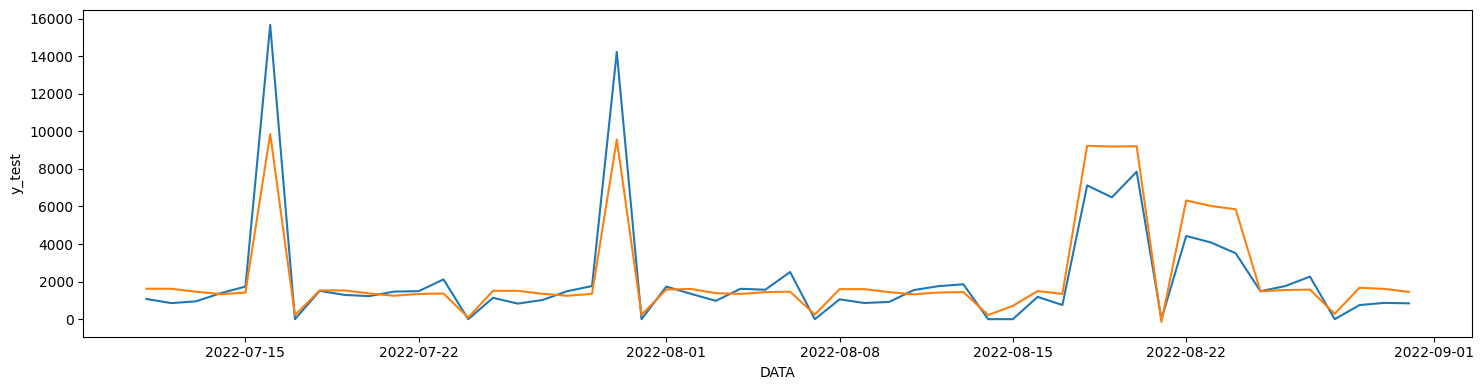

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=xgb_pred, x=xgb_pred.index, y='y_test')
sns.lineplot(data=xgb_pred, x=xgb_pred.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_XGB, rmse_XGB, r2_XGB, mape_XGB, mase_XGB = ff.metryki(y_test, y_predict_xgb)
print(f"MAE: {mae_XGB:.4f}, RMSE: {rmse_XGB:.4f}, R2: {r2_XGB:.4f}, MAPE: {mape_XGB:.4f}%, MASE: {mase_XGB:.4f}")

MAE: 766.6458, RMSE: 1325.4833, R2: 0.8104, MAPE: 41027862528000.0000%, MASE: 0.3742


### Prophet + XGBoost

In [ ]:
# Wczytanie danych
df = pd.read_pickle('/content/drive/MyDrive/DS Projekt/PICKLE/df_3.pkl')
# Ograniczenie danych do jednego klastra oraz wybranie jednego arrtykułu
df = df.loc[df['CLUSTER']==2].drop(['CLUSTER'], axis=1)
df = df.loc[df['ART_ID']==158].drop(['ART_ID', 'GRUPA_ID', 'NAZWA'], axis=1) 
df.set_index('DATA', inplace=True)
#Kopia
df_prophet_XGB = df.copy()

In [ ]:
df_prophet_XGB.head()

CENA_NP  CENA_AP  PRZECENA  CENA_MARKET PROMO_KOD Nr_dn_tyg  \
DATA                                                                      
2019-09-02     5.99     5.99       0.0     5.657993         0         1   
2019-09-03     5.99     5.99       0.0     4.727133         0         2   
2019-09-04     5.99     5.99       0.0     5.464078         0         3   
2019-09-05     7.99     7.99       0.0     7.396029         0         4   
2019-09-06     7.99     7.99       0.0     7.541655         0         5   

           Nr_dn_mies Nr_mies Nr_tyg Nr_rok Dn_handlowy Hot_day Hot_day_Xmass  \
DATA                                                                            
2019-09-02          2       9     36   2019           1       0             0   
2019-09-03          3       9     36   2019           1       0             0   
2019-09-04          4       9     36   2019           1       0             0   
2019-09-05          5       9     36   2019           1       0             0   
2019-09-06          6       9     36   2019           1       0             0   

           Hot_day_Wlkn        HICP            y  
DATA                                              
2019-09-02            0  105.199997  1303.949951  
2019-09-03            0  105.199997  1561.709961  
2019-09-04            0  105.199997   894.440002  
2019-09-05            0  105.199997   689.469971  
2019-09-06            0  105.199997  1078.989990

In [ ]:
#forecast
forecast = prophet_model.predict(df_prophet.iloc[:,:-1])
forecast = forecast.set_index('ds').rename_axis('DATA', axis='index')
forecast.head(1)

trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
DATA                                                                        
2019-09-02  1250.57279 -411.803384  2585.777676   1250.57279   1250.57279   

             CENA_AP  CENA_AP_lower  CENA_AP_upper  CENA_MARKET  \
DATA                                                              
2019-09-02 -0.010039      -0.010039      -0.010039     0.604462   

            CENA_MARKET_lower  CENA_MARKET_upper   CENA_NP  CENA_NP_lower  \
DATA                                                                        
2019-09-02           0.604462           0.604462 -0.122857      -0.122857   

            CENA_NP_upper  Dn_handlowy  Dn_handlowy_lower  Dn_handlowy_upper  \
DATA                                                                           
2019-09-02      -0.122857     0.106762           0.106762           0.106762   

               HICP  HICP_lower  HICP_upper  Hot_day  Hot_day_lower  \
DATA                                                                  
2019-09-02 -0.04355    -0.04355    -0.04355      0.0            0.0   

            Hot_day_upper  Hot_day_Wlkn  Hot_day_Wlkn_lower  \
DATA                                                          
2019-09-02            0.0        -0.003              -0.003   

            Hot_day_Wlkn_upper  Hot_day_Xmass  Hot_day_Xmass_lower  \
DATA                                                                 
2019-09-02              -0.003       0.001595             0.001595   

            Hot_day_Xmass_upper  Nr_dn_mies  Nr_dn_mies_lower  \
DATA                                                            
2019-09-02             0.001595    0.088909          0.088909   

            Nr_dn_mies_upper  Nr_dn_tyg  Nr_dn_tyg_lower  Nr_dn_tyg_upper  \
DATA                                                                        
2019-09-02          0.088909   0.023311         0.023311         0.023311   

             Nr_mies  Nr_mies_lower  Nr_mies_upper    Nr_rok  Nr_rok_lower  \
DATA                                                                         
2019-09-02  0.009167       0.009167       0.009167  0.008605      0.008605   

            Nr_rok_upper    Nr_tyg  Nr_tyg_lower  Nr_tyg_upper  PROMO_KOD  \
DATA                                                                        
2019-09-02      0.008605 -0.013663     -0.013663     -0.013663  -0.087409   

            PROMO_KOD_lower  PROMO_KOD_upper  PRZECENA  PRZECENA_lower  \
DATA                                                                     
2019-09-02        -0.087409        -0.087409 -0.381973       -0.381973   

            PRZECENA_upper  extra_regressors_multiplicative  \
DATA                                                          
2019-09-02       -0.381973                         0.180319   

            extra_regressors_multiplicative_lower  \
DATA                                                
2019-09-02                               0.180319   

            extra_regressors_multiplicative_upper  multiplicative_terms  \
DATA                                                                      
2019-09-02                               0.180319             -0.112027   

            multiplicative_terms_lower  multiplicative_terms_upper    weekly  \
DATA                                                                           
2019-09-02                   -0.112027                   -0.112027 -0.067122   

            weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
DATA                                                                           
2019-09-02     -0.067122     -0.067122 -0.225224     -0.225224     -0.225224   

            additive_terms  additive_terms_lower  additive_terms_upper  \
DATA                                                                     
2019-09-02             0.0                   0.0                   0.0   

                   yhat  
DATA                     
2019-09-02  1110.475302

In [ ]:
prophet_variables = forecast.loc[:, ['trend', 'extra_regressors_multiplicative', 'multiplicative_terms', 'weekly', 'yearly', 'PROMO_KOD_lower']]
df_xgb_prophet = pd.concat([df_prophet_XGB, prophet_variables], axis = 1)
df_xgb_prophet

CENA_NP  CENA_AP  PRZECENA  CENA_MARKET PROMO_KOD Nr_dn_tyg  \
DATA                                                                      
2019-09-02     5.99     5.99       0.0     5.657993         0         1   
2019-09-03     5.99     5.99       0.0     4.727133         0         2   
2019-09-04     5.99     5.99       0.0     5.464078         0         3   
2019-09-05     7.99     7.99       0.0     7.396029         0         4   
2019-09-06     7.99     7.99       0.0     7.541655         0         5   
...             ...      ...       ...          ...       ...       ...   
2022-08-27     6.99     6.99       0.0     6.112804         0         6   
2022-08-28     6.99     6.99       0.0     6.990000         0         7   
2022-08-29     6.99     6.99       0.0     6.989894         0         1   
2022-08-30     6.99     6.99       0.0     6.990000         0         2   
2022-08-31     6.99     6.99       0.0     6.719486         0         3   

           Nr_dn_mies Nr_mies Nr_tyg Nr_rok Dn_handlowy Hot_day Hot_day_Xmass  \
DATA                                                                            
2019-09-02          2       9     36   2019           1       0             0   
2019-09-03          3       9     36   2019           1       0             0   
2019-09-04          4       9     36   2019           1       0             0   
2019-09-05          5       9     36   2019           1       0             0   
2019-09-06          6       9     36   2019           1       0             0   
...               ...     ...    ...    ...         ...     ...           ...   
2022-08-27         27       8     34   2022           1       0             0   
2022-08-28         28       8     34   2022           1       0             0   
2022-08-29         29       8     35   2022           1       0             0   
2022-08-30         30       8     35   2022           1       0             0   
2022-08-31         31       8     35   2022           1       0             0   

           Hot_day_Wlkn        HICP            y        trend  \
DATA                                                            
2019-09-02            0  105.199997  1303.949951  1250.572790   
2019-09-03            0  105.199997  1561.709961  1250.663611   
2019-09-04            0  105.199997   894.440002  1250.754432   
2019-09-05            0  105.199997   689.469971  1250.845253   
2019-09-06            0  105.199997  1078.989990  1250.936074   
...                 ...         ...          ...          ...   
2022-08-27            0  131.399994  2266.419922  1009.047629   
2022-08-28            0  131.399994     0.000000  1008.674856   
2022-08-29            0  131.399994   750.059998  1008.302082   
2022-08-30            0  131.399994   866.820007  1007.929309   
2022-08-31            0  131.399994   843.700012  1007.556535   

            extra_regressors_multiplicative  multiplicative_terms    weekly  \
DATA                                                                          
2019-09-02                         0.180319             -0.112027 -0.067122   
2019-09-03                         0.254775             -0.138848 -0.178372   
2019-09-04                         0.170214             -0.235768 -0.200683   
2019-09-05                         0.008487              0.099855  0.286710   
2019-09-06                        -0.019694              0.158706  0.363761   
...                                     ...                   ...       ...   
2022-08-27                         0.077627              0.406457  0.612808   
2022-08-28                        -0.020305             -1.110957 -0.817101   
2022-08-29                         0.018428             -0.311898 -0.067122   
2022-08-30                         0.004121             -0.427204 -0.178372   
2022-08-31                         0.015616             -0.427868 -0.200683   

              yearly  PROMO_KOD_lower  
DATA                                   
2019-09-02 -0.225224        

In [ ]:
# Definicja kolumn względem typu danych
nominal_columns = ['PROMO_KOD', 'Dn_handlowy', 'Hot_day']
ordinal_columns = ['Hot_day_Xmass', 'Hot_day_Wlkn', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 'Nr_rok']
numeric_columns = ['CENA_MARKET', 'CENA_AP', 'CENA_NP', 'PRZECENA', 'HICP', 'trend', 'extra_regressors_multiplicative', 'multiplicative_terms', 'weekly', 'yearly', 'PROMO_KOD_lower']

# Tworzenie przekształceń
nominal_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
numeric_transformer = MinMaxScaler()

# Tworzenie ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_columns),
        ('ordinal', ordinal_transformer, ordinal_columns),
        ('numeric', numeric_transformer, numeric_columns)
    ])

# Tworzenie pipeline'u
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Przekształcanie danych
X_train, y_train = df_xgb_prophet.loc[df_xgb_prophet.index <='2022-07-10 00:00:00'], df_xgb_prophet.loc[df_xgb_prophet.index <= '2022-07-10 00:00:00']
X_test, y_test = df_xgb_prophet.loc[df_xgb_prophet.index>'2022-07-10 00:00:00'], df_xgb_prophet.loc[df_xgb_prophet.index > '2022-07-10 00:00:00']
X_train = X_train.drop(columns=['y'])
X_test = X_test.drop(columns=['y'])
y_train = y_train['y']
y_test = y_test['y']

In [ ]:
# Parametry
n_estimators_values = [50, 100, 300, 500, 1000, 1500]
learning_rate_values = [0.01, 0.02, 0.05, 0.1]
max_depth_values = [3, 5, 6, 8, 10, 12]

In [ ]:
# Tworzenie kombinacji parametrów
param_combinations_XGB = list(product(n_estimators_values, learning_rate_values, max_depth_values))
len(param_combinations_XGB)

144

In [ ]:
# Inicjalizacja ramki danych do przechowywania wyników metryk dla każdego foldu
results_df_XGB = pd.DataFrame(columns=["Fold", "n_estimators", "learning_rate", "max_depth", "MAE", "RMSE", "R2", "MAPE", "MASE"])

# Tworzenie obiektu TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# Iteracja po foldach
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train_XGB = X_train.iloc[train_index]
    X_test_XGB = X_train.iloc[test_index]
    y_train_XGB = y_train.iloc[train_index]
    y_test_XGB = y_train.iloc[test_index]
    # Kodowanie
    X_train_XGB = pipeline.fit_transform(X_train_XGB)
    X_test_XGB = pipeline.transform(X_test_XGB)
   
    best_rmse = float('inf')
    best_params = None

    # Iteracja po kombinacjach parametrów
    for params in param_combinations_XGB:
        n_estimators, learning_rate, max_depth = params
        XGB = xgb.XGBRegressor(objective='reg:squarederror',
                                n_jobs=-1, 
                                random_state=42,
                                n_estimators=n_estimators,
                                learning_rate=learning_rate,
                                max_depth=max_depth)#,
                                #tree_method='gpu_hist'
                                #)
        XGB.fit(X_train_XGB, y_train_XGB)
        y_pred_XGB = XGB.predict(X_test_XGB)
        rmse = mean_squared_error(y_test_XGB, y_pred_XGB, squared=False)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    # Utworzenie najlepszego modelu
    n_estimators, learning_rate, max_depth = best_params
    XGB = xgb.XGBRegressor(objective='reg:squarederror',
                            n_jobs=-1, 
                            random_state=42,
                            n_estimators=n_estimators,
                            learning_rate=learning_rate,
                            max_depth=max_depth)#,
                                #tree_method='gpu_hist'
                                #)
    XGB.fit(X_train_XGB, y_train_XGB)
    y_pred_XGB = XGB.predict(X_test_XGB)

    # Obliczenie metryk
    best_mae, best_rmse, best_r2, best_mape, best_mase = ff.metryki(y_test_XGB, y_pred_XGB)

    # Dodanie najlepszych wyników metryk do ramki danych
    results_df_XGB = results_df_XGB.append({"Fold": fold, "n_estimators": n_estimators,
                                                        "learning_rate": learning_rate, "max_depth": max_depth,
                                                        "MAE": best_mae, "RMSE": best_rmse, "R2": best_r2,
                                                        "MAPE": best_mape, "MASE": best_mase}, ignore_index=True)

In [ ]:
# Wyświetlenie ramki danych z wynikami metryk dla każdego foldu
results_df_XGB.head()

Fold  n_estimators  learning_rate  max_depth         MAE         RMSE  \
0   0.0         300.0           0.05        3.0  790.608215  1905.650635   
1   1.0         300.0           0.05        6.0  275.672791   639.539551   
2   2.0          50.0           0.10        3.0  379.099762   782.874023   
3   3.0          50.0           0.05        3.0  465.409088   928.228149   
4   4.0        1500.0           0.02        3.0  323.569702   686.056580   

         R2          MAPE      MASE  
0  0.535859  2.154155e+14  0.637456  
1  0.894999  3.632496e+12  0.320107  
2  0.945083  3.523697e+13  0.321150  
3  0.849350  6.758300e+13  0.430210  
4  0.839777  3.214271e+13  0.449319

In [ ]:
# Najlepsze parametry XGBRegressor
print("Najlepsze parametry znalezione:", XGB.get_params())

Najlepsze parametry znalezione: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.02, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 1500, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


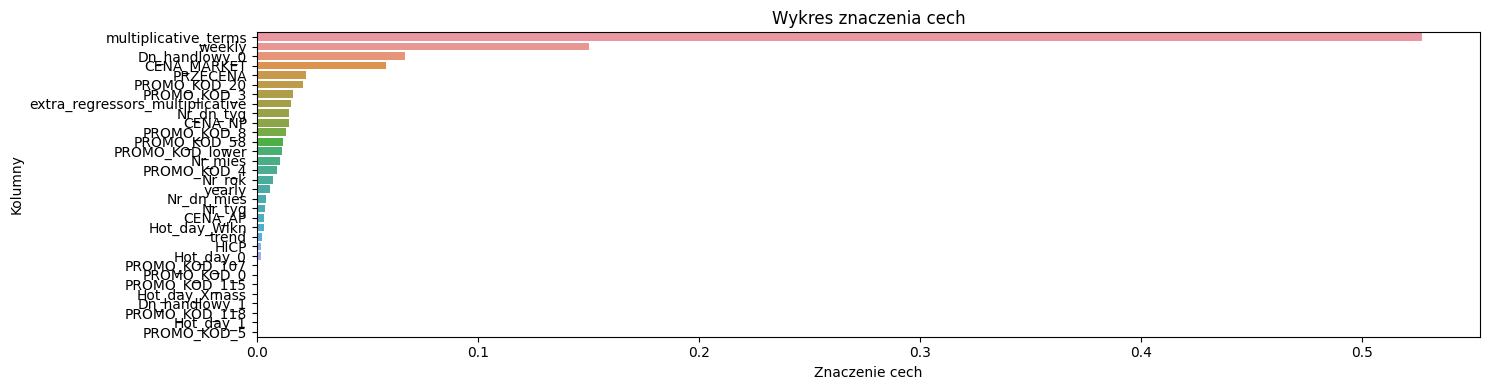

In [ ]:
# Pobieranie znaczenia cech z modelu
importance_scores = XGB.feature_importances_

# Tworzenie słownika mapującego indeksy kolumn na nazwy oryginalne
column_names = []
column_transformers = preprocessor.transformers_
for transformer_name, transformer, column_indices in column_transformers:
    if transformer_name == 'nominal':
        nominal_column_names = transformer.get_feature_names_out(nominal_columns)
        column_names.extend(nominal_column_names)
    elif transformer_name == 'ordinal':
        ordinal_column_names = column_indices
        column_names.extend(ordinal_column_names)
    elif transformer_name == 'numeric':
        numeric_column_names = numeric_columns
        column_names.extend(numeric_column_names)

# Sortowanie cech według znaczenia
sorted_indices = importance_scores.argsort()[::-1]
sorted_column_names = [column_names[i] for i in sorted_indices]
sorted_importance_scores = importance_scores[sorted_indices]

# Generowanie wykresu znaczenia cech z dostosowanymi etykietami przy użyciu Seaborn
plt.figure(figsize=(15, 4))
sns.barplot(x=sorted_importance_scores, y=sorted_column_names, orient='h')
plt.xlabel('Znaczenie cech')
plt.ylabel('Kolumny')
plt.title('Wykres znaczenia cech')
plt.tight_layout()
plt.show()

In [ ]:
# Kodowanie 
X_train_XGB = pipeline.fit_transform(X_train)
X_test_XGB = pipeline.transform(X_test)
# Tworzenie predykcji
XGB.fit(X_train_XGB, y_train)
y_predict_xgb = XGB.predict(X_test_XGB)

In [ ]:
# Tworzenie DataFrame do wizualizacji
xgb_pred = df.loc[df.index >'2022-07-10 00:00:00'][['y']]
xgb_pred['y_test'] = xgb_pred['y']
xgb_pred = xgb_pred.drop('y', axis=1)
xgb_pred['y_predict'] = y_predict_xgb

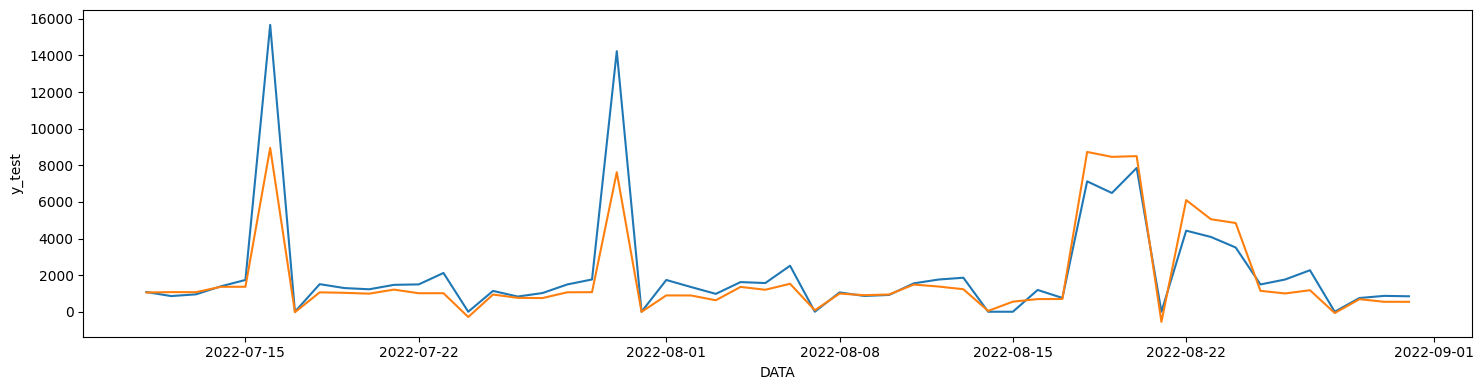

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=xgb_pred, x=xgb_pred.index, y='y_test')
sns.lineplot(data=xgb_pred, x=xgb_pred.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_XGB, rmse_XGB, r2_XGB, mape_XGB, mase_XGB = ff.metryki(y_test, y_predict_xgb)
print(f"MAE: {mae_XGB:.4f}, RMSE: {rmse_XGB:.4f}, R2: {r2_XGB:.4f}, MAPE: {mape_XGB:.4f}%, MASE: {mase_XGB:.4f}")

MAE: 698.0259, RMSE: 1454.3137, R2: 0.7718, MAPE: 31152645734400.0000%, MASE: 0.3407


### Sieć neuronowa - DENSE, model Vanila - OK

In [ ]:
# Konwersja danych na tensory TensorFlow
X_train_tensor = tf.convert_to_tensor(X_train_transformed)
X_test_tensor = tf.convert_to_tensor(X_test_transformed)

In [ ]:
# Budowanie modelu
model_vanilla = Sequential(name="vanilla")
model_vanilla.add(Dense(16, activation='relu', input_shape=(X_train_tensor.shape[1],)))
model_vanilla.add(Dense(8, activation='relu'))
model_vanilla.add(Dense(1, activation='linear'))

# Kompilowanie modelu
optimizer = Adam(learning_rate=0.001)
model_vanilla.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Podsumowanie modelu
model_vanilla.summary()

Model: "vanilla"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                432       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Trenowanie modelu
history_vanilla = model_vanilla.fit(X_train_tensor, y_train, epochs=200, batch_size=32, validation_data=(X_test_tensor, y_test), verbose=0)

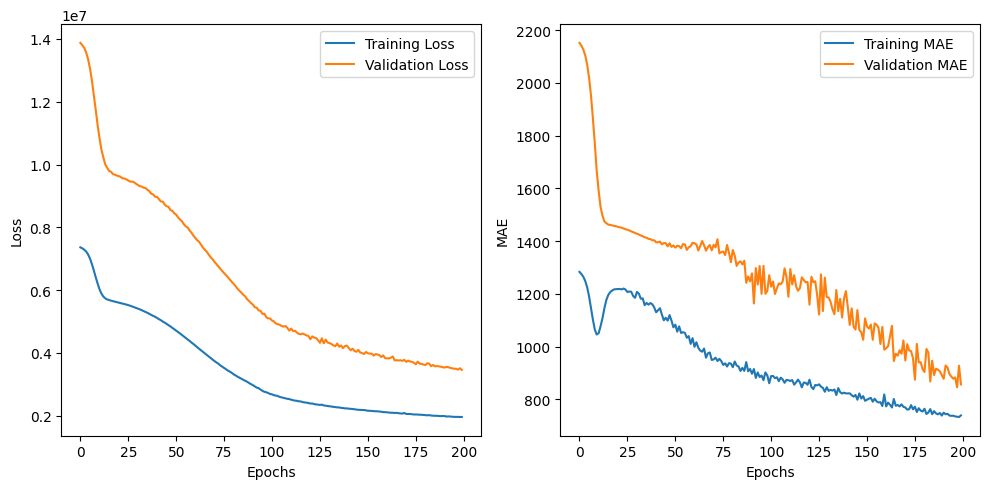

In [ ]:
# Pobieranie danych z historii
loss = history_vanilla.history['loss']
val_loss = history_vanilla.history['val_loss']
mae = history_vanilla.history['mae']
val_mae = history_vanilla.history['val_mae']

# Wizualizacja historii funkcji straty
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Wizualizacja historii metryki MAE
plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Ewaluacja modelu
loss, mae = model_vanilla.evaluate(X_test_tensor, y_test)
print("Strata:", loss)
print("MAE:", mae)

2/2 [==============================] - 0s 11ms/step - loss: 3508882.7500 - mae: 898.6241
Strata: 3508882.75
MAE: 898.6240844726562


In [ ]:
# Tworzenie predykcji
y_predict_dense_vanilla = model_vanilla.predict(X_test_transformed)

2/2 [==============================] - 0s 10ms/step


In [ ]:
# Tworzenie DataFrame do wizualizacji
vanilla_pred = df.loc[df.index >'2022-07-10 00:00:00'][['y']]
vanilla_pred['y_test'] = vanilla_pred['y']
vanilla_pred = vanilla_pred.drop('y', axis=1)
vanilla_pred['y_predict'] = y_predict_dense_vanilla

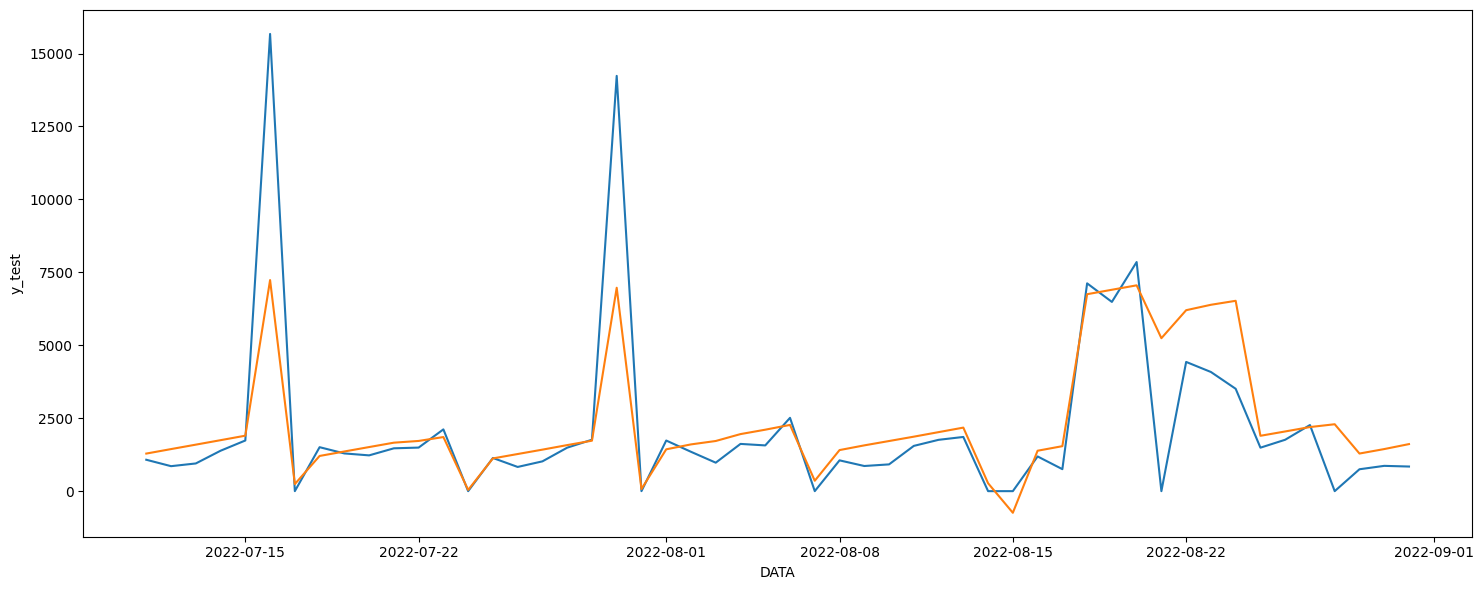

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 6))
sns.lineplot(data=vanilla_pred, x=vanilla_pred.index, y='y_test')
sns.lineplot(data=vanilla_pred, x=vanilla_pred.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_dense_vanilla, rmse_dense_vanilla, r2_dense_vanilla, mape_dense_vanilla, mase_dense_vanilla = ff.metryki(y_test, y_predict_dense_vanilla.reshape(-1))
print(f"MAE: {mae_dense_vanilla:.4f}, RMSE: {rmse_dense_vanilla:.4f}, R2: {r2_dense_vanilla:.4f}, MAPE: {mape_dense_vanilla:.4f}%, MASE: {mase_dense_vanilla:.4f}")

MAE: 898.6241, RMSE: 1873.2013, R2: 0.6214, MAPE: inf%, MASE: 0.4386


### Sieć neuronowa - DENSE, rozbudowana sieć - OK

In [ ]:
# Konwersja danych na tensory TensorFlow
X_train_tensor = tf.convert_to_tensor(X_train_transformed)
X_test_tensor = tf.convert_to_tensor(X_test_transformed)

In [ ]:
# Budowanie modelu
model_dense = Sequential(name='dense')
model_dense.add(Dense(X_train_tensor.shape[1], activation='relu', input_shape=(X_train_tensor.shape[1],)))
model_dense.add(Dropout(0.1))
model_dense.add(Dense(X_train_tensor.shape[1], activation='relu'))
model_dense.add(Dropout(0.1))
model_dense.add(Dense(X_train_tensor.shape[1], activation='relu'))
model_dense.add(Dropout(0.1))
model_dense.add(Dense(16, activation='relu'))
model_dense.add(Dropout(0.1))
model_dense.add(Dense(1, activation='linear'))

# Kompilowanie modelu
optimizer = Adam(learning_rate=0.001)
model_dense.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Podsumowanie modelu
model_dense.summary()

Model: "dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 26)                702       
                                                                 
 dropout (Dropout)           (None, 26)                0         
                                                                 
 dense_4 (Dense)             (None, 26)                702       
                                                                 
 dropout_1 (Dropout)         (None, 26)                0         
                                                                 
 dense_5 (Dense)             (None, 26)                702       
                                                                 
 dropout_2 (Dropout)         (None, 26)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                432   

In [ ]:
# Callback'i
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

callbacks = [early_stopping, reduce_lr]

In [ ]:
# Trenowanie modelu z callback'ami
history_dense = model_dense.fit(X_train_tensor, y_train, epochs=1000, batch_size=32, validation_data=(X_test_tensor, y_test), callbacks=callbacks, verbose=0)

In [ ]:
# Ewaluacja modelu
loss2, mae2 = model_dense.evaluate(X_test_tensor, y_test)
print("Strata:", loss2)
print("MAE:", mae2)

2/2 [==============================] - 0s 7ms/step - loss: 1083863.2500 - mae: 631.8699
Strata: 1083863.25
MAE: 631.869873046875


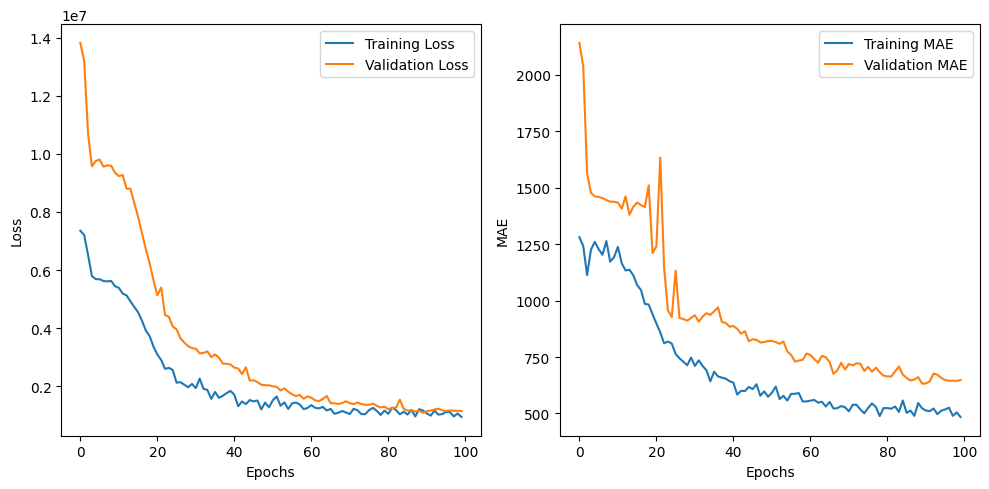

In [ ]:
# Pobieranie danych z historii
loss = history_dense.history['loss']
val_loss = history_dense.history['val_loss']
mae = history_dense.history['mae']
val_mae = history_dense.history['val_mae']

# Wizualizacja historii funkcji straty
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Wizualizacja historii metryki MAE
plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Tworzenie predykcji
y_predict_dense = model_dense.predict(X_test_transformed)

2/2 [==============================] - 0s 8ms/step


In [ ]:
# Tworzenie DataFrame do wizualizacji
dense_pred = df.loc[df.index >'2022-07-10 00:00:00'][['y']]
dense_pred['y_test'] = dense_pred['y']
dense_pred = dense_pred.drop('y', axis=1)
dense_pred['y_predict'] = y_predict_dense

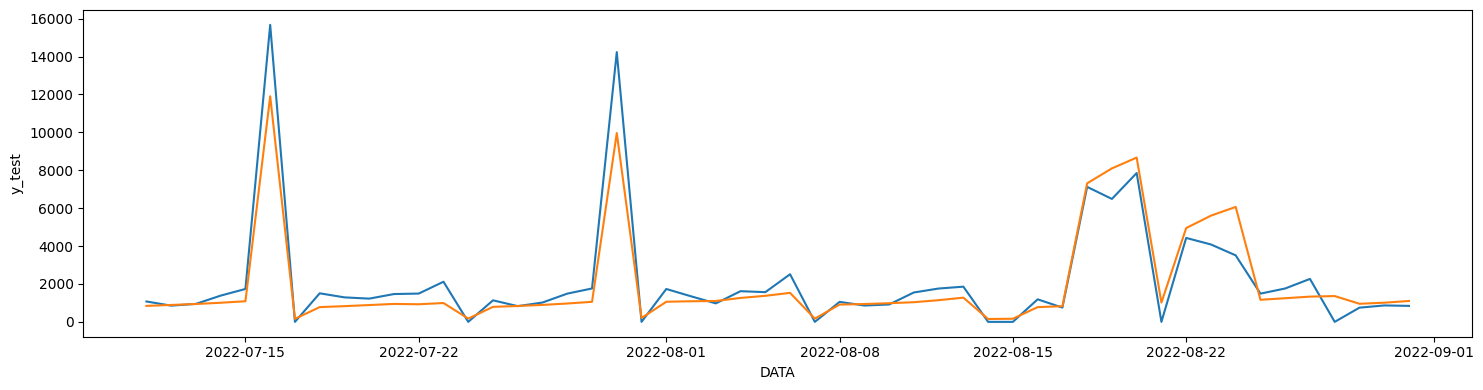

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=dense_pred, x=dense_pred.index, y='y_test')
sns.lineplot(data=dense_pred, x=dense_pred.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_dense, rmse_dense, r2_dense, mape_dense, mase_dense = ff.metryki(y_test, y_predict_dense.reshape(-1))
print(f"MAE: {mae_dense:.4f}, RMSE: {rmse_dense:.4f}, R2: {r2_dense:.4f}, MAPE: {mape_dense:.4f}%, MASE: {mase_dense:.4f}")

MAE: 631.8699, RMSE: 1041.0875, R2: 0.8830, MAPE: inf%, MASE: 0.3084


### Sieć neuronowa rekurencyjna - LSTM - do poprawy / nie działa

In [ ]:
def reshape_data(data, time_steps):
    samples, features = data.shape
    reshaped_data = np.zeros((samples - time_steps + 1, time_steps, features))
    for i in range(samples - time_steps + 1):
        reshaped_data[i] = data[i:i + time_steps]
    return reshaped_data

time_steps = 7
X_train_3d = reshape_data(X_train_transformed, time_steps)
X_test_3d = reshape_data(X_test_transformed, time_steps)
y_train_3d = y_train[time_steps - 1:].values
y_test_3d = y_test[time_steps - 1:].values

In [ ]:
# Parametry modelu
input_shape = X_train_3d.shape[1:]
lstm_units = 24
output_size = 1

In [ ]:
# Budowanie modelu
model_lstm = Sequential(name='lstm')
model_lstm.add(LSTM(lstm_units, input_shape=input_shape, return_sequences=True, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(24, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(output_size))

In [ ]:
# Kompilacja modelu
optimizer = Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
callbacks = [early_stopping, reduce_lr]

In [ ]:
# Trenowanie modelu
history_lstm = model_lstm.fit(X_train_3d, y_train_3d, epochs=200, batch_size=32, validation_data=(X_test_3d, y_test_3d), callbacks=callbacks, verbose=0)

In [ ]:
# Ewaluacja modelu
loss2, mae2 = model_lstm.evaluate(X_test_3d, y_test_3d)
print("Strata:", loss2)
print("MAE:", mae2)

2/2 [==============================] - 0s 9ms/step - loss: 5215203.5000 - mae: 1289.0771
Strata: 5215203.5
MAE: 1289.0771484375


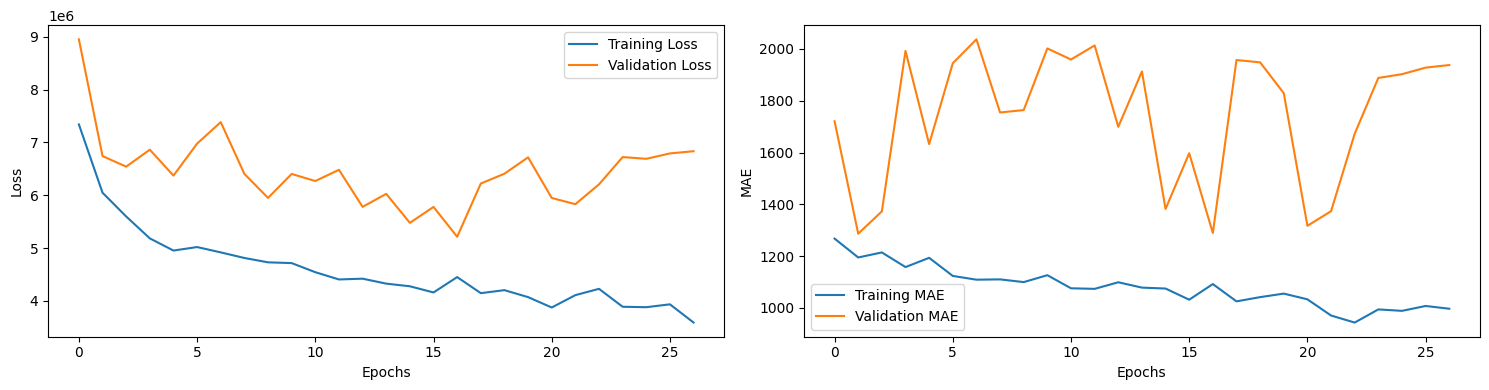

In [ ]:
# Pobieranie danych z historii
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
mae = history_lstm.history['mae']
val_mae = history_lstm.history['val_mae']

# Wizualizacja historii funkcji straty
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Wizualizacja historii metryki MAE
plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Tworzenie predykcji
y_predict_lstm = model_lstm.predict(X_test_3d)

2/2 [==============================] - 0s 7ms/step


In [ ]:
# Tworzenie DataFrame do wizualizacji
dense_pred = df.loc[df.index >'2022-07-16 00:00:00'][['y']]
dense_pred['y_test'] = dense_pred['y']
dense_pred = dense_pred.drop('y', axis=1)
dense_pred = dense_pred[:46]
dense_pred['y_predict'] = y_predict_lstm.reshape(-1)

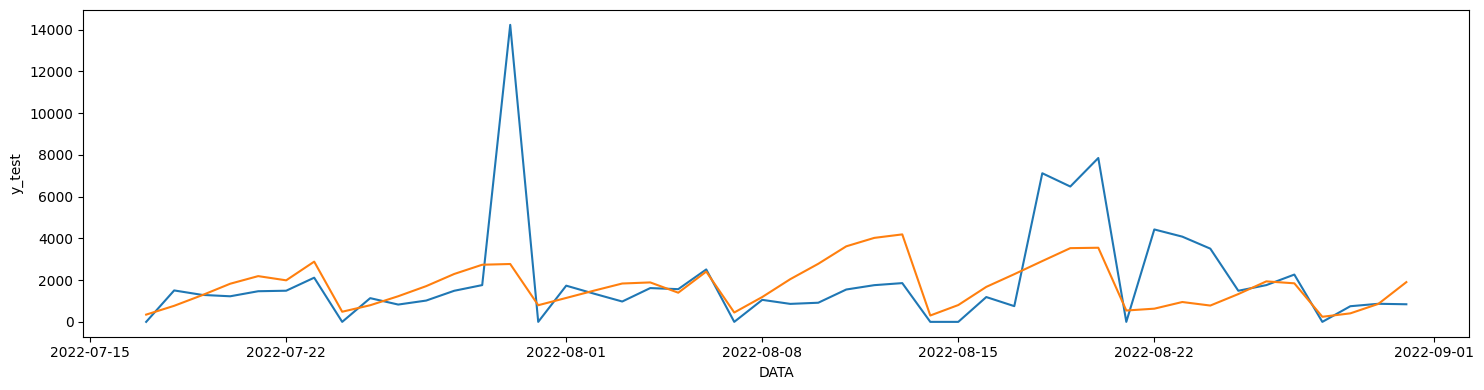

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=dense_pred, x=dense_pred.index, y='y_test')
sns.lineplot(data=dense_pred, x=dense_pred.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae, rmse, r2, mape, mase = ff.metryki(y_test, y_predict_dense.reshape(-1))
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAPE: {mape:.4f}%, MASE: {mase:.4f}")

MAE: 631.8699, RMSE: 1041.0875, R2: 0.8830, MAPE: inf%, MASE: 0.3084


## Budowa modeli oraz testów dla wielowymiarowych szeregów czasowych

In [ ]:
# Definicja kolumn względem typu danych
nominal_columns = ['PROMO_KOD', 'Dn_handlowy', 'Hot_day', 'lag_PROMO_KOD_7', 'lag_PROMO_KOD_14', 'lag_PROMO_KOD_350', 'lag_PROMO_KOD_364', 'lag_PROMO_KOD_378']
ordinal_columns = ['Hot_day_Xmass', 'Hot_day_Wlkn', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 'Nr_rok']
numeric_columns = ['CENA_MARKET', 'CENA_AP', 'CENA_NP', 'PRZECENA', 'HICP',
                  'lag_CENA_NP_7', 'lag_CENA_NP_14', 'lag_CENA_NP_350','lag_CENA_NP_364', 'lag_CENA_NP_378',
                  'lag_CENA_AP_7', 'lag_CENA_AP_14', 'lag_CENA_AP_350', 'lag_CENA_AP_364', 'lag_CENA_AP_378',
                  'lag_CENA_MARKET_7', 'lag_CENA_MARKET_14', 'lag_CENA_MARKET_350', 'lag_CENA_MARKET_364', 'lag_CENA_MARKET_378']

# Tworzenie przekształceń
nominal_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
numeric_transformer = MinMaxScaler()

# Tworzenie ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_columns),
        ('ordinal', ordinal_transformer, ordinal_columns),
        ('numeric', numeric_transformer, numeric_columns)
    ])

# Tworzenie pipeline'u
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Przekształcanie danych
X_train, y_train = df.loc[df.index <='2022-07-10 00:00:00'], df.loc[df.index <= '2022-07-10 00:00:00']
X_test, y_test = df.loc[df.index>'2022-07-10 00:00:00'], df.loc[df.index > '2022-07-10 00:00:00']
X_train = X_train.drop(columns=['y'])
X_test = X_test.drop(columns=['y'])
y_train = y_train['y']
y_test = y_test['y']

# Zastosowanie pipeline'ow
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Ocena

## Ocena wyników

https://christophm.github.io/interpretable-ml-book/
https://shap.readthedocs.io/en/latest/index.html

## Proces przeglądu

# Wdrożenie

## Planowane wdrożenie

In [ ]:
from dask.distributed import Client

In [ ]:
# Utwórz klienta Dask (potrzebny do obliczeń rozproszonych)
client = Client()

# Konwertuj pandas DataFrame na dask DataFrame
dask_df = dd.from_pandas(new_df, npartitions=8)  # określ liczbę partycji

# Oblicz sumę w przód dla każdego ID w oknie 14 dni
dask_df['suma_w_przod'] = dask_df.groupby('ID').rolling('14D', on='DATA')['ILOSC'].sum().reset_index(level=0, drop=True).compute()

# Oblicz sumę wstecz dla każdego ID w oknie 14 dni
dask_df['suma_wstecz'] = dask_df[::-1].groupby('ID').rolling('14D', on='DATA')['ILOSC'].sum().reset_index(level=0, drop=True).compute()

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36799 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:35523
INFO:distributed.scheduler:  dashboard at:           127.0.0.1:36799
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41527'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45369'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:44311', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44311
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:58464
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:43117', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker comp

In [ ]:
#new_df['suma_w_przod'] = new_df.groupby('ID').rolling('14D', on='DATA')['ILOSC'].sum().reset_index(level=0, drop=True)
#new_df['suma_wstecz'] = new_df[::-1].groupby('ID').rolling('14D', on='DATA')['ILOSC'].sum().reset_index(level=0, drop=True)

TypeError: ignored

In [ ]:
# Usuwanie wierszy, gdzie 'suma_w_przod' i 'suma_wstecz' wynoszą zero
new_df = new_df[(new_df['suma_w_przod'] != 0) & (new_df['suma_wstecz'] != 0)]
